In [1]:
#pip install jyquickhelper
from jyquickhelper import add_notebook_menu  
add_notebook_menu()

In [2]:
import sys
print(sys.executable)

C:\Users\belaziw\Anaconda3\envs\new_env\python.exe


## <div class="alert alert-info"><font color='dimgray'> I. Import des Librairies d'Analyse</font> </div>

<div class="alert alert-success">
    
Importons dans un premier temps l'ensemble des librairies qui vont nous servir durant l'entièreté de ce Projet.</div>

In [3]:
import numpy as np
import pandas as pd
import gc
import time
import warnings
from contextlib import contextmanager
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from yellowbrick.model_selection import LearningCurve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import shap
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## <div class="alert alert-info"><font color='dimgray'>II. Fonctions  </font> </div>

In [5]:
def test_remplissage(data):

    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de remplissage", "Nombre de valeurs manquantes"]).sort_values(by="Taux de remplissage", ascending=False)

In [6]:
def confusion_matrix_plot(y_test, y_pred, model_id):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matrice de confusion pour {model_id}")
    plt.show()
    filename = f'Matrice_de_confusion_pour_{model_id}.png'
    plt.savefig(filename)

In [7]:
def roc_auc_plot(clf, X, y, model_id):
    # Calcule les probabilités de la classe positive
    y_proba = clf.predict_proba(X)[:, 1]
    # Calcule et affiche le score ROC AUC
    roc_auc = roc_auc_score(y, y_proba)
    print(f"ROC AUC Score for {model_id}: {roc_auc:.2f}")
    # Génère et affiche la courbe ROC
    RocCurveDisplay.from_estimator(clf, X, y)
    plt.title(f"Courbe ROC pour {model_id} - AUC: {roc_auc:.2f}")
    # Construit le nom du fichier et sauvegarde le graphique
    filename = f'roc_auc_curve_{model_id}.png'
    plt.savefig(filename)
    plt.show()

In [8]:
def metrics_weighted(y_test, y_pred, y_pred_proba):

    # Calcule la précision globale du modèle
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Calcule l'aire sous la courbe ROC (ROC AUC), utile pour les problèmes de classification binaire
    ROC_AUC = roc_auc_score(y_test, y_pred_proba)
     
    
    # Calcule le score F1 pondéré, qui est une moyenne pondérée des scores F1 pour chaque classe
    F1_Score_weighted = metrics.f1_score(y_test, y_pred, average='weighted')
    
    # Calcule la précision pondérée, qui est la moyenne pondérée des précisions pour chaque classe
    Precision_weighted = metrics.precision_score(y_test, y_pred, average='weighted')
    
    # Calcule le rappel pondéré, qui est la moyenne pondérée des rappels pour chaque classe
    Recall_weighted = metrics.recall_score(y_test, y_pred, average='weighted')
    
    # Calcule un score métier en fonction des étiquettes réelles et prédites
    Score_metier = business_scorer(y_test, y_pred)

    return {
        'accuracy': round(Accuracy, 2), 
        'recall weighted': round(Recall_weighted, 2), 
        'precision weighted': round(Precision_weighted, 2),
        'F1 score weighted': round(F1_Score_weighted, 2),
        'ROC_AUC': round(ROC_AUC, 2),
        'score métier': round(Score_metier, 2)
        
    }

In [9]:
def binary_classification_metrics(y_test, y_pred):
    # Calcule la précision globale du modèle
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Calcule le rappel pour la classe positive
    Recall = metrics.recall_score(y_test, y_pred)
    
    # Calcule la précision pour la classe positive
    Precision = metrics.precision_score(y_test, y_pred)
    
    # Calcule le score F1 pour la classe positive
    F1_Score = metrics.f1_score(y_test, y_pred)
    
    # Calcule l'aire sous la courbe ROC (ROC AUC)
    ROC_AUC = metrics.roc_auc_score(y_test, y_pred)
    
    # Retourne un dictionnaire contenant toutes les métriques arrondies à deux chiffres après la virgule
    return {
        'accuracy': round(Accuracy, 2), 
        'recall': round(Recall, 2), 
        'precision': round(Precision, 2),
        'F1 score': round(F1_Score, 2),
        'ROC_AUC': round(ROC_AUC, 2)
    }

## <div class="alert alert-info"><font color='dimgray'>III. Méthodologies d'Évaluation de Modèles de Scoring de Crédit : Création d'un score métier  </font> </div>

### <div class="alert alert-info"><font color='dimgray'>III.1 Objectif  </font> </div>

<div class="alert alert-success">
 
L'objectif est de développer un modèle de scoring de crédit capable de prédire la probabilité de remboursement d'un prêt par un client. L'évaluation des modèles requiert une approche qui combine des mesures statistiques et des considérations métier pour maximiser la performance financière globale et minimiser les risques.
    
</div>

### <div class="alert alert-info"><font color='dimgray'>III.2 Démarche 1 : Évaluation basée sur le Bénéfice/Perte Financier  </font> </div>

**Description**

<div class="alert alert-success">
 
Cette approche évalue l'impact financier global d'un modèle de prédiction en calculant directement les bénéfices (intérêts gagnés sur les prêts remboursés) et les pertes (crédits non remboursés). Elle offre une vue d'ensemble de la performance financière du modèle.
    
</div>

**Avantages**

<div class="alert alert-success">
 
- Fournit une estimation directe de l'impact financier du modèle.
    
- Permet de mesurer l'efficacité globale du modèle en termes de rentabilité.
    
</div>

**Inconvénients**

<div class="alert alert-success">
 
- Peut ne pas capter finement le coût relatif des différents types d'erreurs de prédiction.
    
- Moins flexible pour ajuster le modèle en fonction de priorités métier spécifiques (par exemple, minimiser les pertes dues aux défauts de paiement).
    
</div>

### <div class="alert alert-info"><font color='dimgray'>III.3 Démarche 2 : Évaluation basée sur un Score Métier  </font> </div>

**Description**

<div class="alert alert-success">
 
Cette méthode introduit une fonction de score métier qui pondère différemment les types d'erreurs selon leur impact financier (par exemple, les faux négatifs sont jugés plus coûteux que les faux positifs). L'objectif est de minimiser ce score pour réduire l'impact des erreurs les plus coûteuses.
    
</div>

**Avantages**

<div class="alert alert-success">
 
- Permet de pondérer les erreurs selon leur coût métier, alignant étroitement l'évaluation avec les objectifs financiers.
    
- Offre une flexibilité pour ajuster les poids selon l'évolution des priorités et des stratégies métier.
    
- Concentre l'optimisation du modèle sur la minimisation des risques financiers les plus significatifs.
    
</div>

**Inconvénients**

<div class="alert alert-success">
 
- Nécessite des ajustements et des recalibrages basés sur l'expérience pratique et les retours d'analyse financière.
    
</div>

### <div class="alert alert-info"><font color='dimgray'>III.4 Choix de la Méthodologie  </font> </div>

<div class="alert alert-success">
 
Pour notre objectif de prédire la capacité de remboursement et d'évaluer les modèles sous un angle à la fois statistique et métier, la démarche basée sur Score métier est préférée. 
    
Cette préférence est justifiée par plusieurs raisons :
    
**- Alignement avec les Objectifs Métier :** La capacité à pondérer les erreurs selon leur impact financier permet une optimisation plus ciblée du modèle en fonction des risques financiers spécifiques à l'entreprise.   
    

**- Ajustabilité :** Cette méthode offre la flexibilité nécessaire pour ajuster le modèle en réponse à l'évolution des conditions de marché et des priorités stratégiques. 
    
**- Minimisation des Risques Financiers :** En mettant l'accent sur la réduction des erreurs les plus coûteuses (les faux négatifs), cette approche vise directement à minimiser les pertes financières les plus importantes.
    
</div>

### <div class="alert alert-info"><font color='dimgray'>III.5 Création du Score Métier  </font> </div>

<div class="alert alert-success">
 
La variable cible Target est définie comme suit : 
 
- La valeur **1** indique un client rencontrant des difficultés de paiement, c'est-à-dire ayant un retard de paiement supérieur à X jours sur au moins une des premières Y mensualités du prêt. 
    
- La valeur **0** représente tous les autres cas, c'est-à-dire les clients qui ne rencontrent pas de difficultés de paiement.
</div>

<div class="alert alert-success">
 
Nous envisagons de mettre en place une fonction de score métier qui permet d'évaluer l'impact financier des décisions de prêt basées sur les prédictions de Modele de ML. Cette fonction de score accorde une attention particulière à la distinction entre les faux négatifs et les faux positifs :
    
**- Faux négatif :** un client à qui un prêt est accordé alors qu'il ne sera pas en mesure de le rembourser. Ce cas est considéré comme particulièrement coûteux car il entraîne un risque de perte directe pour l'entreprise.
    
**- Faux positif :** un client à qui un prêt est refusé alors qu'il aurait été en mesure de le rembourser. Bien que ce soit également une erreur de prédiction, son coût est perçu comme moins élevé car il représente une opportunité manquée plutôt qu'une perte directe.
    
</div>

<div class="alert alert-success">
 
- On peut comprendre qu'il y a un plus gros risque de prêter de l'argent à un client qui ne remboursera
pas son prêt, qu'il y a de gain à prêter à un client qui remboursera et payera ses intêrets.

- Il nous faut donc déterminer le coût lorsque l'entreprise prête à un mauvais client comparé au coût de refuser
de prêter à un bon client.

    
**- FN:** Faux Bon Client : Prêt à tort ===> Perte du capital ===> Perte de beaucoup d'argent;
    
**- FP:** Faux Mauvais Client: Refus à tort de prêt ===> Manque à gagner

</div>

**Notre Hypothèse :**

<div class="alert alert-success">
 
**Contexte :**
    
**- Capital initial :** nous disposons d'un capital de départ de 100 (unités monétaires).
    
**- Objectif :** Évaluer l'impact financier des erreurs de classification (FN et FP) sur ce capital.
    
**Faux Négatifs (FN)**
    
**- Scénario FN :** Un client est prédit comme non défaillant (c'est-à-dire, capable de rembourser le prêt) mais ne rembourse pas le prêt. Cela représente une perte directe pour l'entreprise.
    
**- Impact financier FN :** Pour chaque FN, on estime une perte de **50% du capital prêté**. Si le capital prêté est de 100, cela se traduit par une perte de **50 unités monétaires**.
    
    
    
**Faux Positifs (FP)**
    
**- Scénario FP :** Un client est prédit comme défaillant (c'est-à-dire, incapable de rembourser le prêt) alors qu'il aurait pu rembourser. Cela représente un manque à gagner en termes de revenus d'intérêt pour l'entreprise.
    
**- Impact financier FP :** Si l'on suppose que le prêt aurait généré un intérêt de 1% par an, le manque à gagner est calculé sur la moyenne du capital qui aurait pu être prêté (de 100 à 0 sur 10 ans, soit une moyenne de 50). Le manque à gagner annuel est donc de 1% de 50, et sur 10 ans, cela représente 10% de 50, soit 5 unités monétaires.

</div>

In [10]:
from sklearn.metrics import confusion_matrix, make_scorer
def business_scorer(y_true, y_pred):
    """
    Calcul personnalisé du score métier basé sur les coûts des faux négatifs et faux positifs.
    
    Arguments :
    y_true -- array-like de vraies étiquettes de classe.
    y_pred -- array-like de étiquettes prédites.
    
    Retourne :
    Le coût moyen .
    """
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Définir les coûts
    cost_fn = 10  # Coût d'un faux négatif
    cost_fp = 1   # Coût d'un faux positif
    
    # Calculer le coût moyenne pondéré par le nombre total de prédictions
    total_cost = (cost_fn * fn + cost_fp * fp) / (fn + tp + fp + tn)
    
    return total_cost

In [11]:
# Création de l'objet scorer pour l'utiliser avec les modèles 
business_scorer_obj = make_scorer(business_scorer, greater_is_better=False)

## <div class="alert alert-info"><font color='dimgray'>IV. Lecture des données  </font> </div>

In [12]:
train= pd.read_csv('df_train.csv')

In [13]:
test=pd.read_csv('df_test.csv')

In [14]:
train.shape, test.shape

((183128, 248), (45783, 248))

In [15]:
train.head()

,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Laborers,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE_Panel,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Low-skill Laborers,ORGANIZATION_TYPE_Self-employed,...,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_MODE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_AMT_GOODS_PRICE_MAX,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.987305,-36.0,0.0,0.0,0.25,157500.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.300049,0.962891,-358.0,0.0,0.0,0.00,102213.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.981445,-763.0,0.0,0.0,0.00,31500.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.209717,0.981445,-29.0,0.0,0.0,0.00,20335.5,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.000000,0.958496,-238.0,0.0,0.0,0.50,35995.5,0.0


In [16]:
test.head()

,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Laborers,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE_Panel,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Low-skill Laborers,ORGANIZATION_TYPE_Self-employed,...,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_MODE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_AMT_GOODS_PRICE_MAX,TARGET
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.444336,0.979004,-176.0,0.000000,0.0,0.000000,79204.5,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.222168,0.0,0.213623,0.981445,-5.0,0.000000,0.0,0.222168,150349.5,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.981445,-564.0,0.000000,0.0,0.000000,1278000.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.142822,0.0,0.000000,0.979980,-85.0,0.285645,0.0,0.428467,450000.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.981445,-2208.0,0.000000,0.0,0.000000,133470.0,0.0


In [17]:
test_remplissage(train)

,Taux de remplissage,Nombre de valeurs manquantes
NAME_EDUCATION_TYPE_Higher education,100.0,0
NONLIVINGAREA_MEDI,100.0,0
APPROVED_AMT_CREDIT_MAX,100.0,0
BURO_AMT_CREDIT_SUM_MAX,100.0,0
INSTAL_AMT_PAYMENT_MEAN,100.0,0
...,...,...
PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,100.0,0
ACTIVE_DAYS_CREDIT_MIN,100.0,0
PREV_NAME_TYPE_SUITE_nan_MEAN,100.0,0
BURO_DAYS_CREDIT_ENDDATE_MAX,100.0,0


In [18]:
test_remplissage(test)

,Taux de remplissage,Nombre de valeurs manquantes
NAME_EDUCATION_TYPE_Higher education,100.0,0
NONLIVINGAREA_MEDI,100.0,0
APPROVED_AMT_CREDIT_MAX,100.0,0
BURO_AMT_CREDIT_SUM_MAX,100.0,0
INSTAL_AMT_PAYMENT_MEAN,100.0,0
...,...,...
PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,100.0,0
ACTIVE_DAYS_CREDIT_MIN,100.0,0
PREV_NAME_TYPE_SUITE_nan_MEAN,100.0,0
BURO_DAYS_CREDIT_ENDDATE_MAX,100.0,0


In [19]:
train['TARGET'].value_counts(normalize=True)

TARGET
0.0    0.920891
1.0    0.079109
Name: proportion, dtype: float64

In [20]:
test['TARGET'].value_counts(normalize=True)

TARGET
0.0    0.921062
1.0    0.078938
Name: proportion, dtype: float64

## <div class="alert alert-info"><font color='dimgray'>V. Mise en place du suivi MLFlow. </font> </div>

<div class="alert alert-success">
 
Nous pouvons utiliser MLflow pour enregistrer des paramètres de modèle, des métriques et même des artefacts (comme des graphiques de performances) pour chaque modèle que nous évaluons. 
</div>

In [21]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

In [56]:
# Définir le nom de l'expérience : Les noms d'expériences dans MLflow nous permettent d'organiser et de regrouper les exécutions de nos modèles.
experiment_name = 'modele_de_scoring'

# Configurer l'expérience dans MLflow :
mlflow.set_experiment(experiment_name)

# Terminer l'exécution en cours dans MLflow :
mlflow.end_run()

In [23]:
tracking_uri = 'http://127.0.0.1:5000'
mlflow.tracking.set_tracking_uri(tracking_uri)
mlflow.end_run()

In [24]:
def log_mlflow(model, name, run_metrics, fit_time, test_time, confusion_matrix_path=None, roc_auc_plot_path=None, run_params=None):
    # Démarrer un nouveau run MLflow pour enregistrer les informations de cette exécution spécifique
    with mlflow.start_run():
        # Définir le nom de l'exécution pour faciliter l'identification dans l'interface MLflow
        mlflow.set_tag("mlflow.runName", name)
        
        # Enregistrer les paramètres du modèle, si disponibles
        if run_params is not None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
                
        # Enregistrer les métriques du modèle, telles que la précision, le rappel, etc.
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        # Enregistrer le temps d'ajustement du modèle
        mlflow.log_metric("Fit time", fit_time)
        mlflow.log_metric("Test time", test_time)
            
        # Si un chemin vers une matrice de confusion est fourni, enregistrer cet artefact
        if confusion_matrix_path is not None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
        
        # Si un chemin vers un graphique de la courbe ROC-AUC est fourni, enregistrer cet artefact
        if roc_auc_plot_path is not None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        # Enregistrer le modèle lui-même pour une utilisation ou une évaluation future
        mlflow.sklearn.log_model(model, name)
        
    # Afficher un message de confirmation indiquant que les informations ont bien été enregistrées dans MLflow
    print('Run - %s est enregistré dans l\'Expérience - %s' % (name, experiment_name))
    # Note: `mlflow.end_run()` est commenté car le contexte `with mlflow.start_run():` s'occupe déjà de terminer le run.


## <div class="alert alert-info"><font color='dimgray'>V. Modélisation  </font> </div>

<div class="alert alert-success">
 
Avant de plonger dans la modélisation, voyons d'abord ce que signifie chaque score que nous allons calculer et comment la fonction métier va fonctionner dans ce contexte.
</div>

**Scores Statistiques**

<div class="alert alert-success">
 
**Accuracy :** la précision du modèle est considérée comme la mesure la plus standard.La précision est basée sur le nombre de prédictions correctes que le modèle a obtenues dans l’ensemble, quelle que soit la classe. **Le plus grand inconvénient de la précision est le déséquilibre des classes**. En effet, le modèle pourrait atteindre une précision presque parfaite en classant chaque entrée comme la classe la plus peuplée. Mais de toute évidence, ce n’est pas un modèle efficace, même s’il prédit techniquement correctement 99% des données. **En général, j’utilise la précision comme l’une de mes mesures à surveiller lors du réglage ou de l’optimisation d’un modèle, mais pas nécessairement l’objectif ultime.**

**Précision :** La précision est la mesure des vrais positifs divisés par les vrais positifs + faux positifs **(TP/TP+FP)**. Étant donné que les vrais positifs sont dans le numérateur et le dénominateur, les faux positifs ont la véritable influence dans cette équation. Si un modèle a un nombre élevé de faux positifs, le score de précision diminuera (s’aggravera) et si un modèle a un faible nombre de faux positifs, le score augmentera (s’améliorera). 
**Un score parfait serait de 1 car s’il n’y avait pas de faux positifs, il s’agirait d’un nombre divisé par lui-même qui serait 1.**


**Recall (Rappel) :** Le rappel est la mesure des vrais positifs divisés par les vrais positifs + faux négatifs **(TP/TP+FN)**. Cette équation est similaire à la précision, mais il s’agit maintenant des faux négatifs. Étant donné que les faux négatifs sont dans le dénominateur, si le nombre de faux négatifs est élevé, le score de rappel diminuera (s’aggravera) et si le nombre de faux négatifs est faible, le score de rappel augmentera (s’améliorera). 
**Un score de rappel parfait serait de 1, car s’il n’y avait pas de faux négatifs, il s’agirait d’un nombre divisé par lui-même.**

       
**F1-Score :** La précision et le rappel sont un compromis, car la réduction des faux négatifs conduit souvent à plus de faux positifs et vice versa. Le score F1 est calculé comme 2*(précision*rappel)/(précision+rappel) et est considéré comme l’équilibre entre la précision et le rappel.
**Si les faux négatifs et les faux positifs sont également indésirables et que vous voulez une métrique qui tentera de trouver la meilleure harmonie entre les deux, envisagez d’utiliser le score F1.**
    
**Spécificité :** Le pourcentage de vrais négatifs correctement identifiés parmi tous les cas réellement négatifs. Elle mesure la capacité du modèle à identifier correctement les négatifs.

**ROC, AUC :** La courbe ROC (Reciever Operating Characteristic) est un graphique représentant les performances d'un modèle de classification pour tous les seuils de classification. Cette courbe trace le taux de vrais positifs en fonction du taux de faux positifs. L'aire sous la courbe (AUC). Il s'agit simplement de l'aire sous la courbe ROC. Cette métrique est comprise entre 0 et 1, un meilleur modèle obtenant un score plus élevé. Un modèle qui se contente de deviner au hasard
aura une AUC ROC de 0,5.    
</div>

**Chargement et préparation des données**

In [25]:
train.head()

,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Laborers,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE_Panel,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Low-skill Laborers,ORGANIZATION_TYPE_Self-employed,...,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_MODE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_AMT_GOODS_PRICE_MAX,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.987305,-36.0,0.0,0.0,0.25,157500.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.300049,0.962891,-358.0,0.0,0.0,0.00,102213.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.981445,-763.0,0.0,0.0,0.00,31500.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.209717,0.981445,-29.0,0.0,0.0,0.00,20335.5,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.000000,0.958496,-238.0,0.0,0.0,0.50,35995.5,0.0


In [26]:
test.head()

,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Laborers,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE_Panel,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Low-skill Laborers,ORGANIZATION_TYPE_Self-employed,...,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_MODE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_AMT_GOODS_PRICE_MAX,TARGET
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.444336,0.979004,-176.0,0.000000,0.0,0.000000,79204.5,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.222168,0.0,0.213623,0.981445,-5.0,0.000000,0.0,0.222168,150349.5,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.981445,-564.0,0.000000,0.0,0.000000,1278000.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.142822,0.0,0.000000,0.979980,-85.0,0.285645,0.0,0.428467,450000.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.981445,-2208.0,0.000000,0.0,0.000000,133470.0,0.0


In [27]:
# Séparer les features et la cible
X_train = train.drop('TARGET', axis=1)
y_train = train['TARGET']

In [28]:
X_test = test.drop('TARGET', axis=1)
y_test = test['TARGET']

In [29]:
X_train.shape, X_test.shape

((183128, 247), (45783, 247))

In [30]:
y_train.shape, y_test.shape

((183128,), (45783,))

### <div class="alert alert-info"><font color='dimgray'>V.1 Modélisation : Cas d'étude n°1 : Evaluation des modèles avec traitement de l'équilibre des classes et avec les parametres par defaut </font> </div>

<div class="alert alert-success">
 

 
**Test des modèles avec une intégration de l'équilibrage des classes avec SMOTE**

**- Objectif :** Examiner l'effet de l'équilibrage des classes sur la performance des modèles dans un contexte de données déséquilibrées.

**- Approche :** Appliquer SMOTE pour l'oversampling de la classe minoritaire dans le pipeline de traitement des données avant d'évaluer les modèles.

- Ratio de SMOTE fixé à 0.5.

</div>

In [31]:
# Initialisation des composants du pipeline
smote = SMOTE(random_state=11, sampling_strategy=0.5) # Initialisation de SMOTE avec sampling_strategy=0.5
scaler = RobustScaler()  # Le RobustScaler est choisi car il est moins sensible aux valeurs aberrantes.

In [32]:
# Entrinement de modèle sur 3 jeux de données différents pour s'assurer de sa reproductibilité
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [33]:
def classifier_pipeline(classifier):
    '''
    Crée un pipeline en utilisant SMOTE pour l'équilibrage des classes avec une stratégie de rééchantillonnage de 0.5,
    un scaler pour la normalisation des données, et un classificateur spécifié en paramètre.
    
    Paramètres :
    - classifier : l'instance d'un classificateur de scikit-learn.
    
    Retour :
    - pipe : un pipeline prêt à être ajusté avec des données.
    '''
    # Création du pipeline avec SMOTE pour l'équilibrage des classes avec sampling_strategy=0.5,
    # un scaler pour la normalisation, et le classificateur spécifié.
    pipe = imbpipeline(steps=[['smote', smote],      # Applique SMOTE pour l'équilibrage des classes avec sampling_strategy=0.5
                               ['scaler', scaler],    # Applique une mise à l'échelle robuste
                               ['classifier', classifier]])  # Intègre le classificateur passé en paramètre
    
    return pipe

**1. Dummy Classifier**

In [34]:
name_DC = 'DummyClassifier'

In [35]:
pipeline_DC = imbpipeline(steps = [['scaler', RobustScaler()],
                                ['classifier', DummyClassifier(strategy="most_frequent")]])

In [36]:
grid_search_DC = GridSearchCV(estimator=pipeline_DC,
                              param_grid = {},
                              scoring=business_scorer_obj,
                              cv=3,
                              n_jobs=-1)

In [37]:
grid_search_DC.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[['scaler', RobustScaler()],
                                       ['classifier',
                                        DummyClassifier(strategy='most_frequent')]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [38]:
best_model_DC = grid_search_DC.best_estimator_

In [39]:
y_pred_train_DC = best_model_DC.predict(X_train)

In [40]:
fit_time_DC = grid_search_DC.cv_results_['mean_fit_time']

In [41]:
fit_time_DC

array([2.82741912])

In [42]:
y_proba_train_DC = best_model_DC.predict_proba(X_train)[:, 1] 

In [43]:
metrics_train_DC = metrics_weighted(y_train, y_pred_train_DC, y_proba_train_DC)
metrics_train_DC

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


{'accuracy': 0.92,
 'recall weighted': 0.92,
 'precision weighted': 0.85,
 'F1 score weighted': 0.88,
 'ROC_AUC': 0.5,
 'score métier': 0.79}

In [44]:
pd.DataFrame([metrics_train_DC])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.92,0.92,0.85,0.88,0.5,0.79


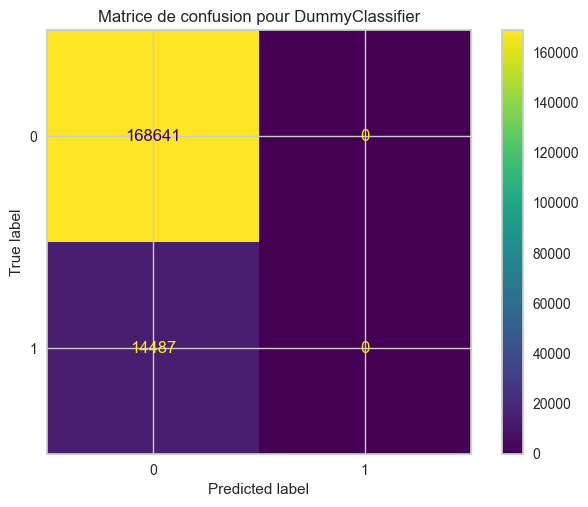

None


<Figure size 800x550 with 0 Axes>

In [45]:
confusion_matrix_train_DC = confusion_matrix_plot(y_train, y_pred_train_DC, name_DC)
print(confusion_matrix_train_DC)

ROC AUC Score for DummyClassifier: 0.50


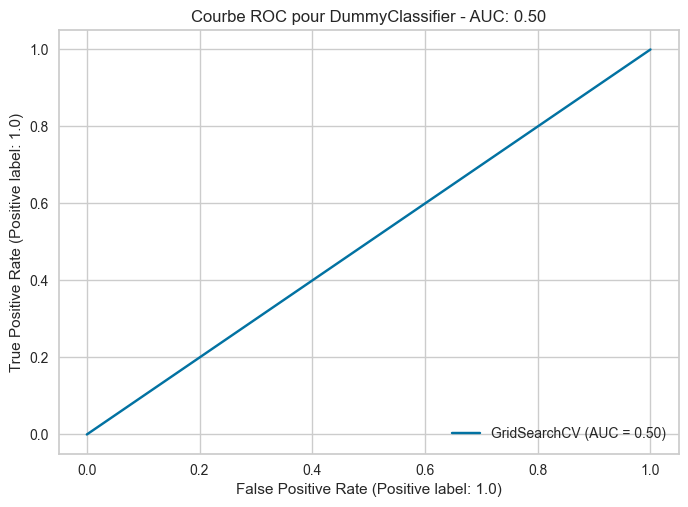

In [46]:
roc_auc_train_DC = roc_auc_plot(grid_search_DC, X_train, y_train, name_DC)

In [47]:
start_test_time_DC = time.time()
y_pred_test_DC = best_model_DC.predict(X_test)
test_time_DC = time.time() - start_test_time_DC

In [48]:
test_time_DC

0.10400009155273438

In [49]:
y_proba_test_DC = best_model_DC.predict_proba(X_test)[:, 1] 

In [50]:
metrics_test_DC = metrics_weighted(y_test, y_pred_test_DC, y_proba_test_DC)
metrics_test_DC

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


{'accuracy': 0.92,
 'recall weighted': 0.92,
 'precision weighted': 0.85,
 'F1 score weighted': 0.88,
 'ROC_AUC': 0.5,
 'score métier': 0.79}

In [51]:
pd.DataFrame([metrics_test_DC])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.92,0.92,0.85,0.88,0.5,0.79


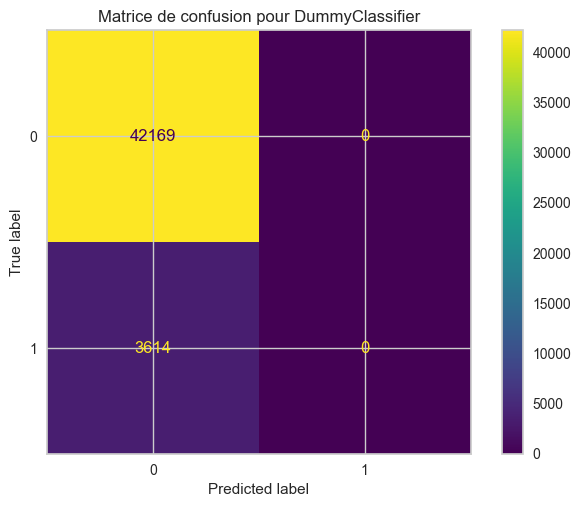

None


<Figure size 800x550 with 0 Axes>

In [52]:
confusion_matrix_test_DC = confusion_matrix_plot(y_test, y_pred_test_DC, name_DC)
print(confusion_matrix_test_DC)

ROC AUC Score for DummyClassifier: 0.50


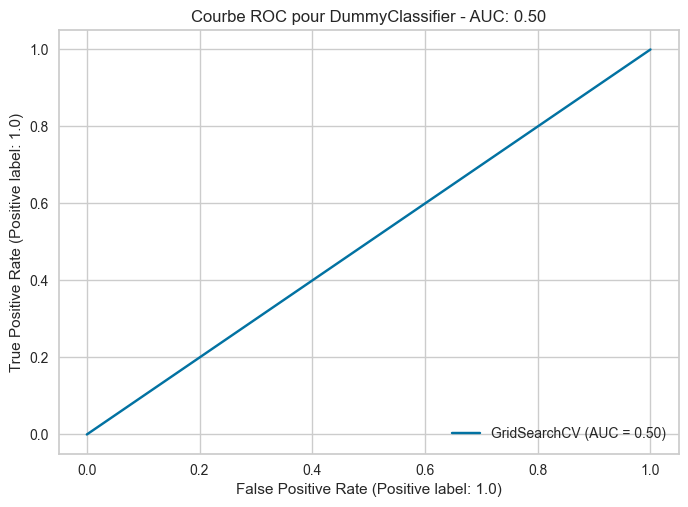

In [53]:
roc_auc_test_DC = roc_auc_plot(grid_search_DC, X_test, y_test, name_DC)
roc_auc_test_DC

In [54]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_DC))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42169
         1.0       0.00      0.00      0.00      3614

    accuracy                           0.92     45783
   macro avg       0.46      0.50      0.48     45783
weighted avg       0.85      0.92      0.88     45783



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [57]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_DC, name_DC, metrics_test_DC, fit_time_DC,test_time_DC, 'Matrice_de_confusion_pour_DummyClassifier.png', 'roc_auc_curve_DummyClassifier.png', run_params=None)

Run - DummyClassifier est enregistré dans l'Expérience - modele_de_scoring


Setuptools is replacing distutils.


In [58]:
# Initialisation des composants du pipeline
smote = SMOTE(random_state=11, sampling_strategy=0.5) # Initialisation de SMOTE avec sampling_strategy=0.5
scaler = RobustScaler()  # Le RobustScaler est choisi car il est moins sensible aux valeurs aberrantes.

In [59]:
# Entrinement de modèle sur 3 jeux de données différents pour s'assurer de sa reproductibilité
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [60]:
def classifier_pipeline(classifier):
    '''
    Crée un pipeline en utilisant SMOTE pour l'équilibrage des classes avec une stratégie de rééchantillonnage de 0.5,
    un scaler pour la normalisation des données, et un classificateur spécifié en paramètre.
    
    Paramètres :
    - classifier : l'instance d'un classificateur de scikit-learn.
    
    Retour :
    - pipe : un pipeline prêt à être ajusté avec des données.
    '''
    # Création du pipeline avec SMOTE pour l'équilibrage des classes avec sampling_strategy=0.5,
    # un scaler pour la normalisation, et le classificateur spécifié.
    pipe = imbpipeline(steps=[['smote', smote],      # Applique SMOTE pour l'équilibrage des classes avec sampling_strategy=0.5
                               ['scaler', scaler],    # Applique une mise à l'échelle robuste
                               ['classifier', classifier]])  # Intègre le classificateur passé en paramètre
    
    return pipe


**2. Régression logisitique**

In [61]:
name_LR_SMOTE = 'LogisticRegression_SMOTE'

In [62]:
classifier_LR = LogisticRegression()

In [63]:
LR_SMOTE_pipeline = classifier_pipeline(classifier_LR)

In [64]:
param_grid_LR= {}
grid_search_LR_SMOTE = GridSearchCV(estimator=LR_SMOTE_pipeline,
                           param_grid=param_grid_LR,
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [65]:
grid_search_LR_SMOTE.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['smote',
                                        SMOTE(random_state=11,
                                              sampling_strategy=0.5)],
                                       ['scaler', RobustScaler()],
                                       ['classifier', LogisticRegression()]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [66]:
best_model_LR_SMOTE=grid_search_LR_SMOTE.best_estimator_

In [67]:
y_pred_train_LR_SMOTE = best_model_LR_SMOTE.predict(X_train)

In [68]:
fit_time_train_LR_SMOTE = grid_search_LR_SMOTE.cv_results_['mean_fit_time']

In [69]:
fit_time_train_LR_SMOTE

array([33.70755363])

In [70]:
y_proba_train_LR_SMOTE = best_model_LR_SMOTE.predict_proba(X_train)[:, 1] 

In [71]:
metrics_train_LR_SMOTE = metrics_weighted(y_train, y_pred_train_LR_SMOTE, y_proba_train_LR_SMOTE)
metrics_train_LR_SMOTE

{'accuracy': 0.89,
 'recall weighted': 0.89,
 'precision weighted': 0.86,
 'F1 score weighted': 0.87,
 'ROC_AUC': 0.61,
 'score métier': 0.75}

In [72]:
pd.DataFrame([metrics_train_LR_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.89,0.89,0.86,0.87,0.61,0.75


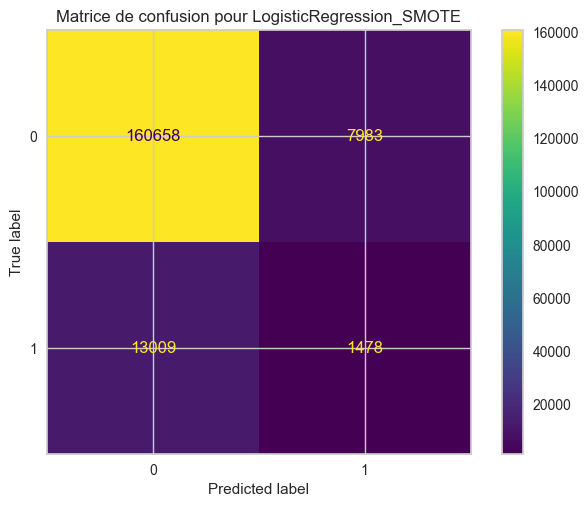

None


<Figure size 800x550 with 0 Axes>

In [73]:
confusion_matrix_train_LR_SMOTE = confusion_matrix_plot(y_train, y_pred_train_LR_SMOTE, name_LR_SMOTE)
print(confusion_matrix_train_LR_SMOTE)

ROC AUC Score for LogisticRegression_SMOTE: 0.61


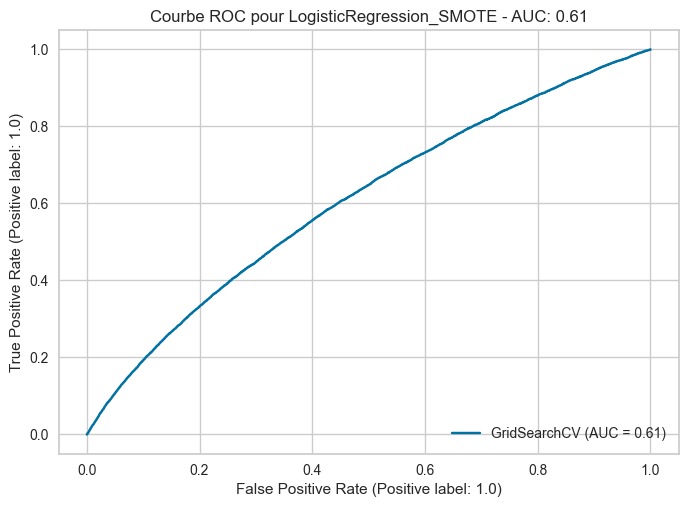

In [74]:
roc_auc_train_LR_SMOTE = roc_auc_plot(grid_search_LR_SMOTE, X_train, y_train, name_LR_SMOTE)

In [75]:
start_test_time_LR_SMOTE = time.time()
y_pred_test_LR_SMOTE = best_model_LR_SMOTE.predict(X_test)
test_time_LR_SMOTE = time.time() - start_test_time_LR_SMOTE

In [76]:
test_time_LR_SMOTE

0.3227710723876953

In [77]:
y_proba_test_LR_SMOTE = best_model_LR_SMOTE.predict_proba(X_test)[:, 1] 

In [78]:
metrics_test_LR_SMOTE = metrics_weighted(y_test, y_pred_test_LR_SMOTE, y_proba_test_LR_SMOTE)
metrics_test_LR_SMOTE

{'accuracy': 0.89,
 'recall weighted': 0.89,
 'precision weighted': 0.86,
 'F1 score weighted': 0.87,
 'ROC_AUC': 0.62,
 'score métier': 0.75}

In [79]:
pd.DataFrame([metrics_test_LR_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.89,0.89,0.86,0.87,0.62,0.75


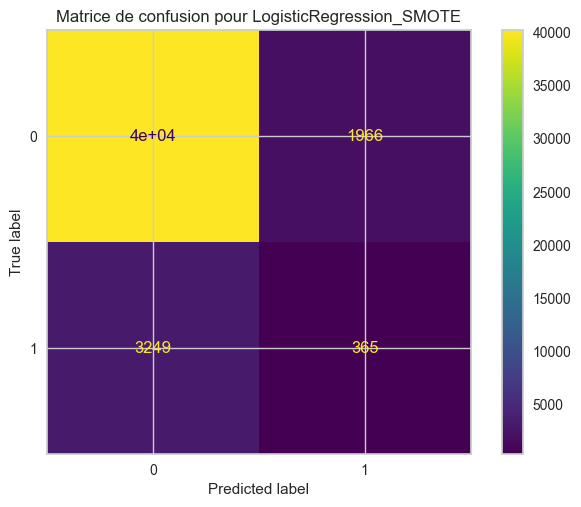

None


<Figure size 800x550 with 0 Axes>

In [80]:
confusion_matrix_LR_SMOTE = confusion_matrix_plot(y_test, y_pred_test_LR_SMOTE, name_LR_SMOTE)
print(confusion_matrix_LR_SMOTE)

ROC AUC Score for LogisticRegression_SMOTE: 0.62


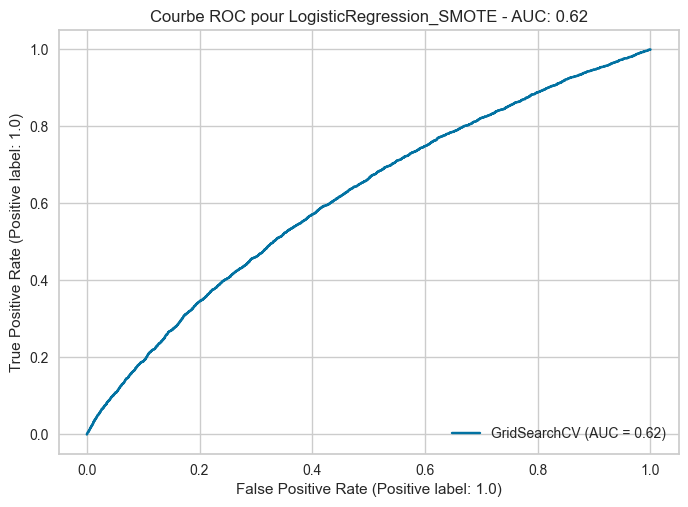

In [81]:
roc_auc_train_LR_SMOTE = roc_auc_plot(grid_search_LR_SMOTE, X_test, y_test, name_LR_SMOTE)

In [82]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_LR_SMOTE))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     42169
         1.0       0.16      0.10      0.12      3614

    accuracy                           0.89     45783
   macro avg       0.54      0.53      0.53     45783
weighted avg       0.86      0.89      0.87     45783



In [83]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_LR_SMOTE, name_LR_SMOTE, metrics_test_LR_SMOTE, fit_time_train_LR_SMOTE,test_time_LR_SMOTE, 'Matrice_de_confusion_pour_LogisticRegression_SMOTE.png', 'roc_auc_curve_LogisticRegression_SMOTE.png', run_params=None)

Run - LogisticRegression_SMOTE est enregistré dans l'Expérience - modele_de_scoring


**Bien que l'accuracy soit satisfaisante, le score métier se révèle élevé 0.75 et un ROC AUC de 0.62 limite notre capacité à distinguer correctement les faux négatifs, comme le démontre clairement la matrice de confusion.**

**3. Random Forest**

In [84]:
name_RF_SMOTE = 'RandomForestClassifier_Smote'

In [85]:
classifier_RF = RandomForestClassifier()

In [86]:
FR_SMOTE_pipeline = classifier_pipeline(classifier_RF)

In [87]:
param_grid_RF= {}
grid_search_RF_SMOTE = GridSearchCV(estimator=FR_SMOTE_pipeline,
                           param_grid=param_grid_RF,
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [88]:
grid_search_RF_SMOTE.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['smote',
                                        SMOTE(random_state=11,
                                              sampling_strategy=0.5)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        RandomForestClassifier()]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [89]:
best_model_RF_SMOTE=grid_search_RF_SMOTE.best_estimator_

In [90]:
y_pred_train_RF_SMOTE = best_model_RF_SMOTE.predict(X_train)

In [91]:
fit_time_train_RF_SMOTE = grid_search_RF_SMOTE.cv_results_['mean_fit_time']

In [92]:
fit_time_train_RF_SMOTE

array([639.42179926])

In [93]:
y_proba_train_RF_SMOTE = best_model_RF_SMOTE.predict_proba(X_train)[:, 1] 

In [94]:
metrics_train_RF_SMOTE= metrics_weighted(y_train, y_pred_train_RF_SMOTE, y_proba_train_RF_SMOTE)
metrics_train_RF_SMOTE

{'accuracy': 1.0,
 'recall weighted': 1.0,
 'precision weighted': 1.0,
 'F1 score weighted': 1.0,
 'ROC_AUC': 1.0,
 'score métier': 0.0}

In [95]:
pd.DataFrame([metrics_train_RF_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,1.0,1.0,1.0,1.0,1.0,0.0


Les résultats obtenus indiquent **une performance parfaite** sur  **l'ensemble d'entraînement (X_train, y_train)** avec une accuracy, un ROC AUC, des scores F1, précision et rappel pondérés tous à 1.0, tandis que le score métier est à 0.0, ce qui est idéal pour ce dernier.

Bien que ces scores puissent initialement sembler excellents, ils soulèvent effectivement des préoccupations concernant **un possible surapprentissage (overfitting).**

**Courbe d'Apprentissage**

In [96]:
from sklearn.model_selection import learning_curve

# Définition de la fonction pour tracer la courbe d'apprentissage
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='roc_auc')
    
    # Calcul de la moyenne et de l'écart-type des scores d'entraînement et de test
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracé de la courbe d'apprentissage
    plt.figure()
    plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score ROC AUC")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score sur l'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score sur la validation croisée")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [97]:
X_train_sub = X_train[:10000]  
y_train_sub = y_train[:10000]

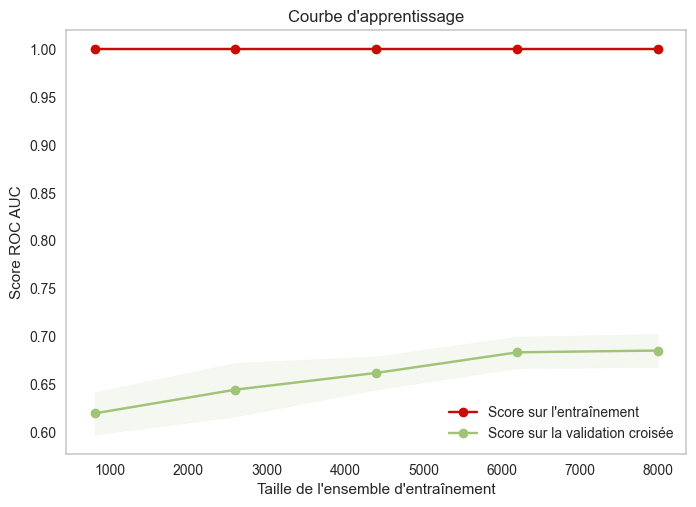

In [100]:
# Tracer la courbe d'apprentissage pour le modèle RandomForest
plot_learning_curve(classifier_RF, X_train_sub, y_train_sub)

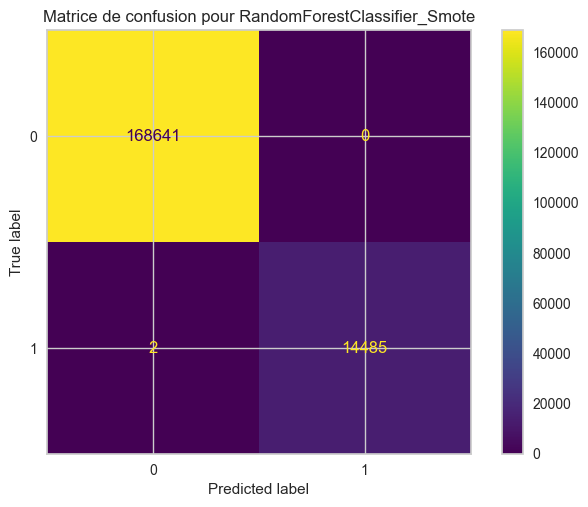

None


<Figure size 800x550 with 0 Axes>

In [98]:
confusion_matrix_train_RF_SMOTE = confusion_matrix_plot(y_train, y_pred_train_RF_SMOTE, name_RF_SMOTE)
print(confusion_matrix_train_RF_SMOTE)

ROC AUC Score for RandomForestClassifier_Smote: 1.00


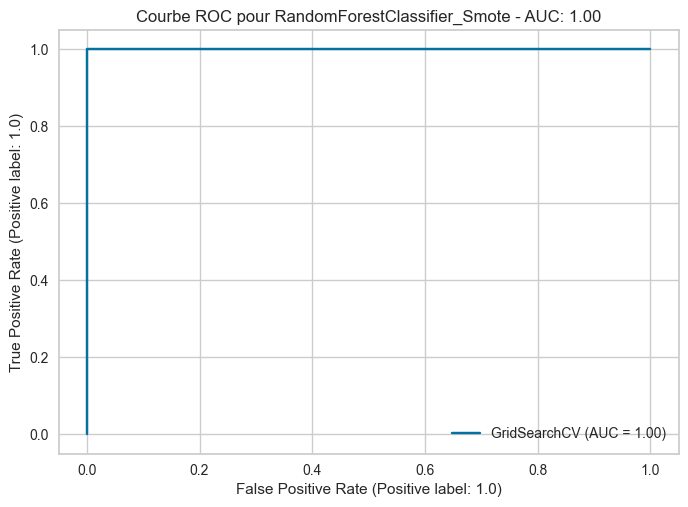

In [99]:
roc_auc_train_RF_SMOTE = roc_auc_plot(grid_search_RF_SMOTE, X_train, y_train, name_RF_SMOTE)

In [100]:
start_test_time_RF_SMOTE = time.time()
y_pred_test_RF_SMOTE = best_model_RF_SMOTE.predict(X_test)
test_time_RF_SMOTE = time.time() - start_test_time_RF_SMOTE

In [101]:
test_time_RF_SMOTE

2.4589648246765137

In [102]:
y_proba_test_RF_SMOTE = best_model_RF_SMOTE.predict_proba(X_test)[:, 1] 
metrics_test_RF_SMOTE = metrics_weighted(y_test, y_pred_test_RF_SMOTE, y_proba_test_RF_SMOTE)
metrics_test_RF_SMOTE

{'accuracy': 0.92,
 'recall weighted': 0.92,
 'precision weighted': 0.88,
 'F1 score weighted': 0.88,
 'ROC_AUC': 0.71,
 'score métier': 0.79}

In [103]:
pd.DataFrame([metrics_test_RF_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.92,0.92,0.88,0.88,0.71,0.79


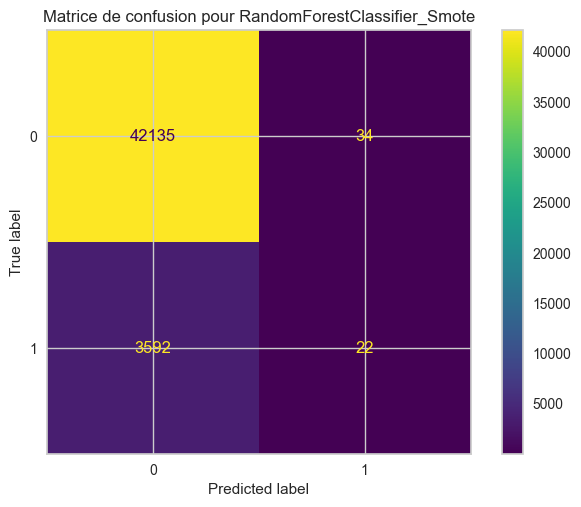

None


<Figure size 800x550 with 0 Axes>

In [104]:
confusion_matrix_RF_SMOTE = confusion_matrix_plot(y_test, y_pred_test_RF_SMOTE, name_RF_SMOTE)
print(confusion_matrix_RF_SMOTE)

ROC AUC Score for RandomForestClassifier_Smote: 0.71


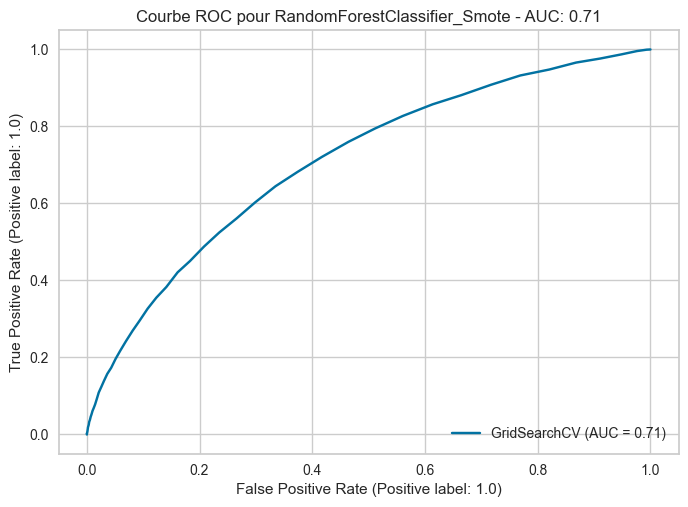

In [105]:
roc_auc_test_RF_SMOTE = roc_auc_plot(grid_search_RF_SMOTE, X_test, y_test, name_RF_SMOTE)
roc_auc_test_RF_SMOTE

In [106]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_RF_SMOTE))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42169
         1.0       0.39      0.01      0.01      3614

    accuracy                           0.92     45783
   macro avg       0.66      0.50      0.49     45783
weighted avg       0.88      0.92      0.88     45783



**Les résultats sur le jeu de test et la courbe d'apprentissage montre qu'il y a d'overfitting pour ce modèle.**

In [107]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_RF_SMOTE, name_RF_SMOTE, metrics_test_RF_SMOTE, fit_time_train_RF_SMOTE,test_time_RF_SMOTE, 'Matrice_de_confusion_pour_RandomForestClassifier_Smote.png', 'roc_auc_curve_RandomForestClassifier_Smote.png', run_params=None)

Run - RandomForestClassifier_Smote est enregistré dans l'Expérience - modele_de_scoring


**4. LGBMClassifier**

In [108]:
name_LGBM_SMOTE = 'LGBMClassifier_SMOTE'

In [109]:
classifier_LGBM = LGBMClassifier(objective='binary')

In [110]:
LGBM_SMOTE_pipeline = classifier_pipeline(classifier_LGBM)

In [111]:
param_grid_LGBM= {}
grid_search_LGBM_SMOTE = GridSearchCV(estimator=LGBM_SMOTE_pipeline,
                           param_grid=param_grid_LGBM,
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [112]:
grid_search_LGBM_SMOTE.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 84320, number of negative: 168641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.540331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62386
[LightGBM] [Info] Number of data points in the train set: 252961, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333332 -> initscore=-0.693153
[LightGBM] [Info] Start training from score -0.693153


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['smote',
                                        SMOTE(random_state=11,
                                              sampling_strategy=0.5)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        LGBMClassifier(objective='binary')]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [113]:
best_model_LGBM_SMOTE=grid_search_LGBM_SMOTE.best_estimator_

In [114]:
y_pred_train_LGBM_SMOTE = best_model_LGBM_SMOTE.predict(X_train)

In [115]:
fit_time_train_LGBM_SMOTE = grid_search_LGBM_SMOTE.cv_results_['mean_fit_time']

In [116]:
fit_time_train_LGBM_SMOTE

array([55.82566524])

In [117]:
y_proba_train_LGBM_SMOTE = best_model_LGBM_SMOTE.predict_proba(X_train)[:, 1] 
metrics_train_LGBM_SMOTE= metrics_weighted(y_train, y_pred_train_LGBM_SMOTE, y_proba_train_LGBM_SMOTE)
metrics_train_LGBM_SMOTE

{'accuracy': 0.92,
 'recall weighted': 0.92,
 'precision weighted': 0.9,
 'F1 score weighted': 0.89,
 'ROC_AUC': 0.81,
 'score métier': 0.76}

In [118]:
pd.DataFrame([metrics_train_LGBM_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.92,0.92,0.9,0.89,0.81,0.76


**Courbe d'apprentissage**

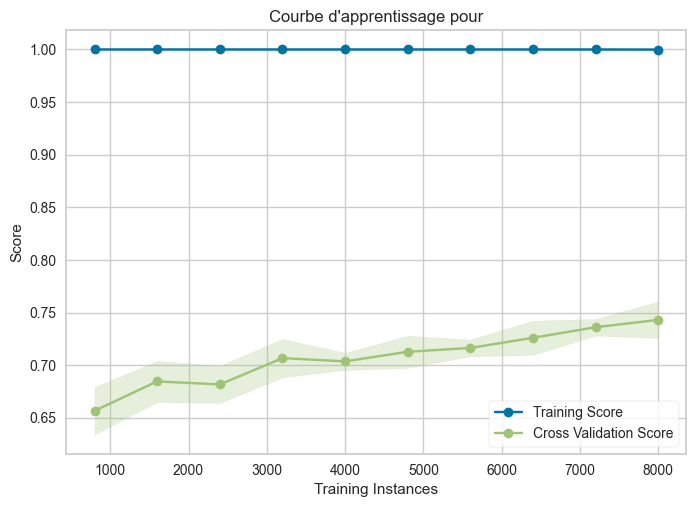

<Axes: title={'center': "Courbe d'apprentissage pour"}, xlabel='Training Instances', ylabel='Score'>

In [119]:
#probleme de mémoire
# sous-échantillonnage de votre ensemble de données
X_train_sub = X_train[:10000] 
y_train_sub = y_train[:10000]
# Utilisez X_train_sub et y_train_sub dans la fonction
visualizer = LearningCurve(
    best_model_LGBM_SMOTE, scoring='roc_auc', cv=5, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, title=f"Courbe d'apprentissage pour"
    )
    
# Ajustement des données au visualiseur
visualizer.fit(X_train_sub, y_train_sub)
    
# Affichage du graphique
visualizer.show()

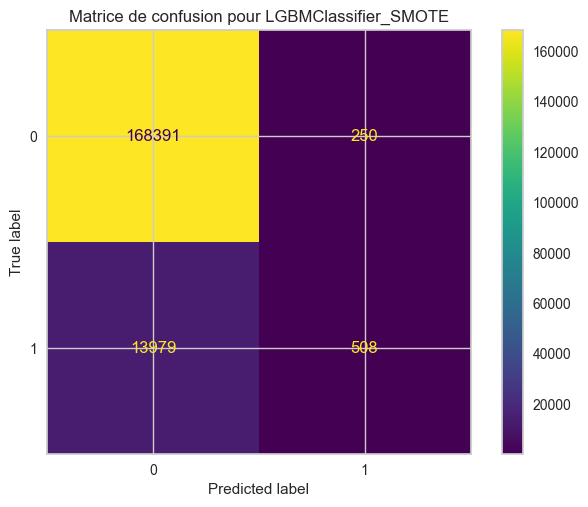

None


<Figure size 800x550 with 0 Axes>

In [120]:
confusion_matrix_train_LGBM_SMOTE = confusion_matrix_plot(y_train, y_pred_train_LGBM_SMOTE, name_LGBM_SMOTE)
print(confusion_matrix_train_LGBM_SMOTE)

ROC AUC Score for LGBMClassifier_SMOTE: 0.81


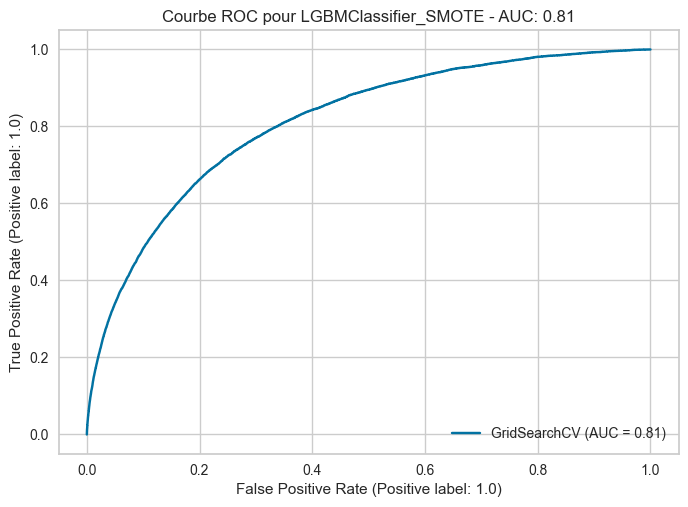

In [121]:
roc_auc_train_LGBM_SMOTE = roc_auc_plot(grid_search_LGBM_SMOTE, X_train, y_train, name_LGBM_SMOTE)

In [122]:
start_test_time_LGBM_SMOTE = time.time()
y_pred_test_LGBM_SMOTE = best_model_LGBM_SMOTE.predict(X_test)
test_time_LGBM_SMOTE = time.time() - start_test_time_LGBM_SMOTE

In [123]:
test_time_LGBM_SMOTE

0.4978163242340088

In [124]:
y_proba_test_LGBM_SMOTE = best_model_LGBM_SMOTE.predict_proba(X_test)[:, 1] 
metrics_test_LGBM_SMOTE = metrics_weighted(y_test, y_pred_test_LGBM_SMOTE, y_proba_test_LGBM_SMOTE)
metrics_test_LGBM_SMOTE

{'accuracy': 0.92,
 'recall weighted': 0.92,
 'precision weighted': 0.89,
 'F1 score weighted': 0.89,
 'ROC_AUC': 0.77,
 'score métier': 0.77}

In [125]:
pd.DataFrame([metrics_test_LGBM_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.92,0.92,0.89,0.89,0.77,0.77


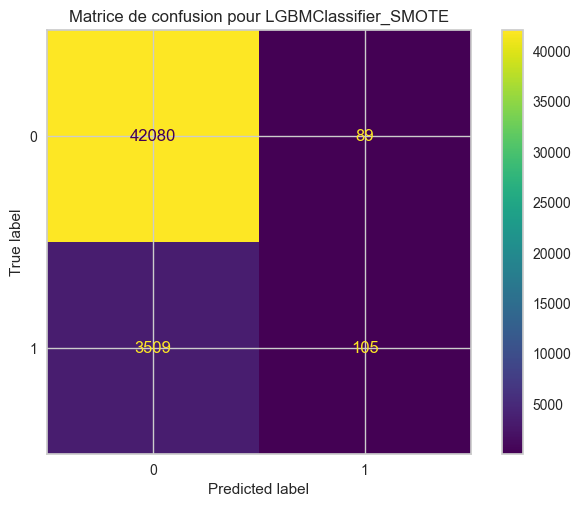

None


<Figure size 800x550 with 0 Axes>

In [126]:
confusion_matrix_LGBM_SMOTE = confusion_matrix_plot(y_test, y_pred_test_LGBM_SMOTE, name_LGBM_SMOTE)
print(confusion_matrix_LGBM_SMOTE)

ROC AUC Score for LGBMClassifier_SMOTE: 0.77


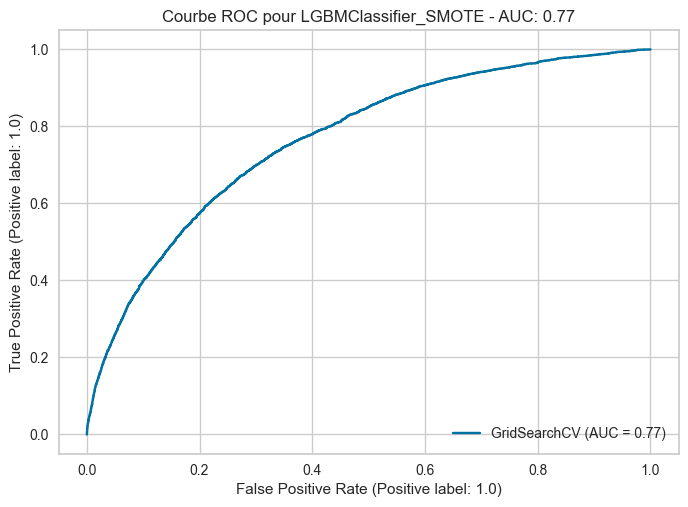

In [127]:
roc_auc_test_LGBM_SMOTE = roc_auc_plot(grid_search_LGBM_SMOTE, X_test, y_test, name_LGBM_SMOTE)
roc_auc_test_LGBM_SMOTE

In [128]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_LGBM_SMOTE))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     42169
         1.0       0.54      0.03      0.06      3614

    accuracy                           0.92     45783
   macro avg       0.73      0.51      0.51     45783
weighted avg       0.89      0.92      0.89     45783



**ROC AUC et score métier a amélioré**

In [129]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_LGBM_SMOTE, name_LGBM_SMOTE, metrics_test_LGBM_SMOTE, fit_time_train_LGBM_SMOTE,test_time_LGBM_SMOTE, 'Matrice_de_confusion_pour_LGBMClassifier_SMOTE.png', 'roc_auc_curve_LGBMClassifier_SMOTE.png', run_params=None)

Run - LGBMClassifier_SMOTE est enregistré dans l'Expérience - modele_de_scoring


**5. XGBOOST**

In [130]:
name_XGB_SMOTE = 'XGBoost_Smote'

In [131]:
classifier_XGB = XGBClassifier()

In [132]:
XGB_SMOTE_pipeline = classifier_pipeline(classifier_XGB)

In [133]:
param_grid_XGB= {}
grid_search_XGB_SMOTE = GridSearchCV(estimator=XGB_SMOTE_pipeline,
                           param_grid=param_grid_XGB,
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [134]:
grid_search_XGB_SMOTE.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['smote',
                                        SMOTE(random_state=11,
                                              sampling_strategy=0.5)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_roun...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [135]:
best_model_XGB_SMOTE=grid_search_XGB_SMOTE.best_estimator_

In [136]:
y_pred_train_XGB_SMOTE = best_model_XGB_SMOTE.predict(X_train)

In [137]:
fit_time_train_XGB_SMOTE = grid_search_XGB_SMOTE.cv_results_['mean_fit_time']

In [138]:
fit_time_train_XGB_SMOTE

array([57.92228127])

In [139]:
y_proba_train_XGB_SMOTE = best_model_XGB_SMOTE.predict_proba(X_train)[:, 1] 
metrics_train_XGB_SMOTE= metrics_weighted(y_train, y_pred_train_XGB_SMOTE, y_proba_train_XGB_SMOTE)

metrics_train_XGB_SMOTE

{'accuracy': 0.93,
 'recall weighted': 0.93,
 'precision weighted': 0.93,
 'F1 score weighted': 0.91,
 'ROC_AUC': 0.9,
 'score métier': 0.68}

In [140]:

pd.DataFrame([metrics_train_XGB_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.93,0.93,0.93,0.91,0.9,0.68


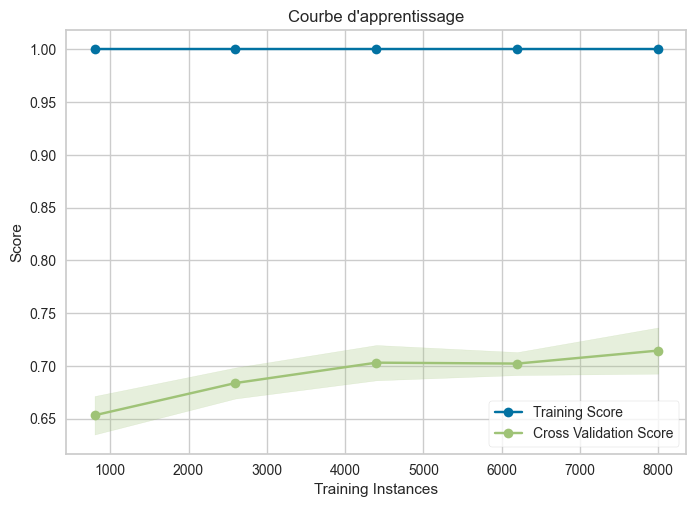

<Axes: title={'center': "Courbe d'apprentissage"}, xlabel='Training Instances', ylabel='Score'>

In [141]:
# Utilisez X_train_sub et y_train_sub dans la fonction
visualizer = LearningCurve(
    best_model_XGB_SMOTE, scoring='roc_auc', cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, title=f"Courbe d'apprentissage"
    )
    
# Ajustement des données au visualiseur
visualizer.fit(X_train_sub, y_train_sub)
    
# Affichage du graphique
visualizer.show()

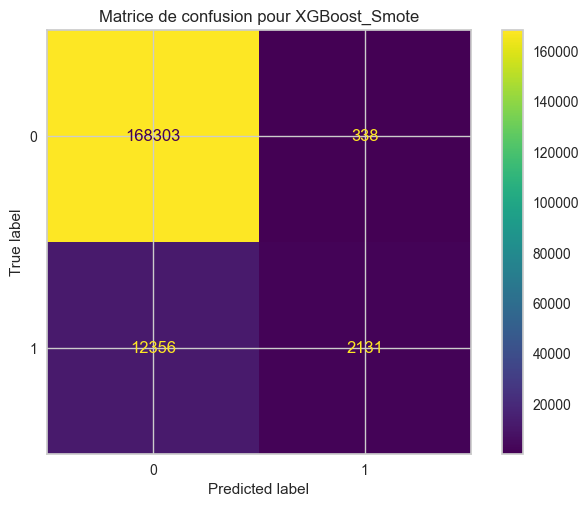

None


<Figure size 800x550 with 0 Axes>

In [142]:
confusion_matrix_train_XGB_SMOTE = confusion_matrix_plot(y_train, y_pred_train_XGB_SMOTE, name_XGB_SMOTE)
print(confusion_matrix_train_XGB_SMOTE)

ROC AUC Score for XGBoost_Smote: 0.90


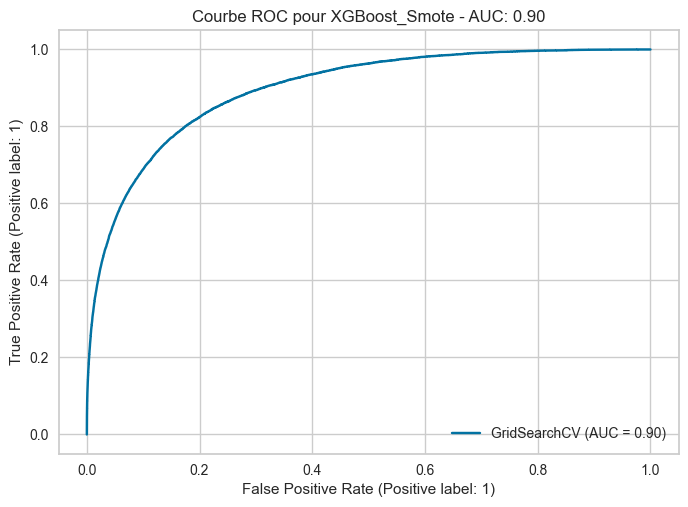

In [143]:
roc_auc_train_XGB_SMOTE= roc_auc_plot(grid_search_XGB_SMOTE, X_train, y_train, name_XGB_SMOTE)

In [144]:
start_test_time_XGB_SMOTE = time.time()
y_pred_test_XGB_SMOTE = best_model_XGB_SMOTE.predict(X_test)
test_time_XGB_SMOTE = time.time() - start_test_time_XGB_SMOTE

In [145]:
test_time_XGB_SMOTE

0.18396353721618652

In [146]:
y_proba_test_XGB_SMOTE = best_model_XGB_SMOTE.predict_proba(X_test)[:, 1] 
metrics_test_XGB_SMOTE = metrics_weighted(y_test, y_pred_test_XGB_SMOTE, y_proba_test_XGB_SMOTE)
metrics_test_XGB_SMOTE

{'accuracy': 0.92,
 'recall weighted': 0.92,
 'precision weighted': 0.88,
 'F1 score weighted': 0.89,
 'ROC_AUC': 0.76,
 'score métier': 0.75}

In [147]:
pd.DataFrame([metrics_test_XGB_SMOTE])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.92,0.92,0.88,0.89,0.76,0.75


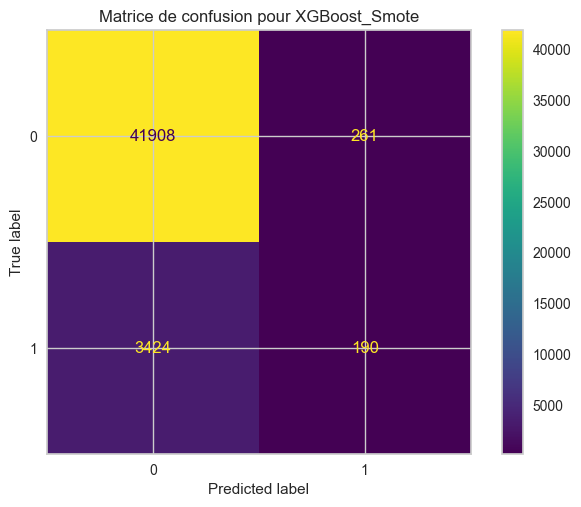

None


<Figure size 800x550 with 0 Axes>

In [148]:
confusion_matrix_XGB_SMOTE = confusion_matrix_plot(y_test, y_pred_test_XGB_SMOTE, name_XGB_SMOTE)
print(confusion_matrix_XGB_SMOTE)


ROC AUC Score for XGBoost_Smote: 0.76


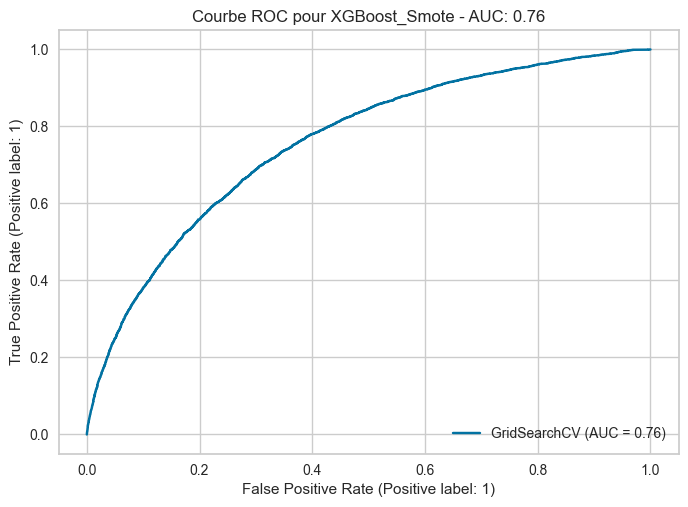

In [149]:
roc_auc_test_XGB_SMOTE = roc_auc_plot(grid_search_XGB_SMOTE, X_test, y_test, name_XGB_SMOTE)
roc_auc_test_XGB_SMOTE

In [150]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_XGB_SMOTE))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     42169
         1.0       0.42      0.05      0.09      3614

    accuracy                           0.92     45783
   macro avg       0.67      0.52      0.53     45783
weighted avg       0.88      0.92      0.89     45783



**Nous obtenons pour l'instant le score métier le plus faible avec ce modèle et un résultat de roc auc assez bien**

In [151]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_XGB_SMOTE, name_XGB_SMOTE, metrics_test_XGB_SMOTE, fit_time_train_XGB_SMOTE,test_time_XGB_SMOTE, 'Matrice_de_confusion_pour_XGBoost_Smote.png', 'roc_auc_curve_XGBoost_Smote.png', run_params=None)

Run - XGBoost_Smote est enregistré dans l'Expérience - modele_de_scoring


**Comparaison**

In [152]:
# Convertir chaque dictionnaire de métriques en DataFrame et ajouter une colonne pour le nom du modèle
df_LR = pd.DataFrame([metrics_test_LR_SMOTE])
df_LR['Model'] = name_LR_SMOTE
df_LR['Train_Time'] = fit_time_train_LR_SMOTE
df_LR['Evaluation_Time'] = test_time_LR_SMOTE

df_RF = pd.DataFrame([metrics_test_RF_SMOTE])
df_RF['Model'] = name_RF_SMOTE
df_RF['Train_Time'] = fit_time_train_RF_SMOTE
df_RF['Evaluation_Time'] = test_time_RF_SMOTE

df_LGBM = pd.DataFrame([metrics_test_LGBM_SMOTE])
df_LGBM['Model'] = name_LGBM_SMOTE
df_LGBM['Train_Time'] = fit_time_train_LGBM_SMOTE
df_LGBM['Evaluation_Time'] = test_time_LGBM_SMOTE

df_XGB = pd.DataFrame([metrics_test_XGB_SMOTE])
df_XGB['Model'] = name_XGB_SMOTE
df_XGB['Train_Time'] = fit_time_train_XGB_SMOTE
df_XGB['Evaluation_Time'] = test_time_XGB_SMOTE

In [153]:
# Concaténer les DataFrames en une seule DataFrame
frames = [df_LR, df_RF, df_LGBM, df_XGB]
result_df = pd.concat(frames).reset_index(drop=True)
# Concaténer les DataFrames en une seule DataFrame
frames = [df_LR, df_RF, df_LGBM, df_XGB]
result_df = pd.concat(frames).reset_index(drop=True)
# Réorganiser les colonnes pour que 'Model' soit la première colonne
cols = ['Model'] + [col for col in result_df.columns if col != 'Model']
result_df = result_df[cols]

In [154]:
result_df

,Model,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier,Train_Time,Evaluation_Time
0,LogisticRegression_SMOTE,0.89,0.89,0.86,0.87,0.62,0.75,33.707554,0.322771
1,RandomForestClassifier_Smote,0.92,0.92,0.88,0.88,0.71,0.79,639.421799,2.458965
2,LGBMClassifier_SMOTE,0.92,0.92,0.89,0.89,0.77,0.77,55.825665,0.497816
3,XGBoost_Smote,0.92,0.92,0.88,0.89,0.76,0.75,57.922281,0.183964


<div class="alert alert-success">
 
**Métriques Clés :**

**- Accuracy :** La précision globale du modèle sur les données de test.

**- Recall Weighted :** Le rappel pondéré, qui tient compte de l'équilibre des classes.

**- Precision Weighted :** La précision pondérée, également ajustée pour l'équilibre des classes.

**- F1 Score Weighted :** Le score F1 pondéré, une moyenne harmonique de la précision et du rappel.

**- ROC_AUC :** L'aire sous la courbe ROC, un indicateur de la capacité du modèle à distinguer entre les classes.

**- Score Métier :** Une métrique spécifique à l'application ou au domaine d'application.

**- Train_Time :** Le temps nécessaire pour entraîner le modèle.

**- Evaluation_Time :** Le temps nécessaire pour évaluer le modèle sur l'ensemble de test.

**Analyse des Résultats :**

**- Performance Générale :** Tous les modèles, à l'exception du DummyClassifier, ont des performances similaires en termes d'accuracy, recall weighted,
precision weighted, et F1 score weighted, avec des valeurs autour de 0.92 pour l'accuracy et 0.88-0.89 pour le F1 score weighted. Cela indique une performance globalement élevée et similaire entre ces modèles sur les données testées.

**- Différenciation par ROC_AUC :** Le DummyClassifier a un score ROC_AUC significativement plus bas (0.50), ce qui était attendu car il s'agit d'un modèle de base. Les autres modèles ont des scores ROC_AUC plus élevés, avec LGBMClassifier ayant le score ROC_AUC le plus élevé (0.78), suivi de près par XGBClassifier (0.76) et RandomForestClassifier (0.72). 

Cela suggère que **LGBMClassifier** est légèrement meilleur pour distinguer entre les classes positives et négatives.

**- Score Métier :** Les scores métier varient de 0.74 à 0.79. Cependant, **LGBMClassifier** possede le score le plus bas. 

**- Temps d'Entraînement et d'Évaluation :** **RandomForestClassifier** prend **le plus de temps** à s'entraîner (748.19 secondes), tandis que **LGBMClassifier et XGBClassifier** sont beaucoup plus rapides, ce qui les rend plus pratiques pour l'entraînement sur de grands ensembles de données. Le DummyClassifier est le plus rapide, comme prévu, mais il est nettement moins performant.

**- Meilleure Performance Générale :** **LGBMClassifier** semble être le meilleur équilibre entre haute performance (notamment en termes de ROC_AUC) et efficacité (temps d'entraînement et d'évaluation raisonnables) mais aussi en terme de score metier (le plus bas).

**- Efficacité vs Performance :** Si l'efficacité d'entraînement est une priorité, **LGBMClassifier et XGBClassifier** sont de bons choix. 
**RandomForestClassifier**, bien qu'efficace, nécessite plus de temps d'entraînement, de plus les résultats sur le jeu de test confirme qu'il y a un overfitting pour ce modèle : score métier très élevé vs score à 0 pour le jeu d'entrainement.

**- Choix du Modèle :** Pour les prochaines etapes, on a choisit de continuer avec **LGBMClassifier et XGBClassifier**
</div>

<div class="alert alert-success">
Regardons si les résultats peuvent s'améliorer en optimisant les hyperparamètres
</div>

### <div class="alert alert-info"><font color='dimgray'>V.3 Modélisation : Cas d'étude n°3 : Optimisation des hyper paramètres. </font> </div>

<div class="alert alert-success">

**Optimisation**
    
- Les hyperparamètres correspondent aux paramètres intrinsèques d'un modèle. Il est possible d'identifier les hyperparamètres optimaux grâce à des grilles de recherche (gridsearch). Elles permettent de tester un ou plusieurs paramètres et cherchent ceux qui vont optimiser une métrique choisie.

- Le cas d'étude n°3 concerne l'optimisation des hyperparamètres pour les modèles sélectionnés, en utilisant la validation croisée (GridSearchCV) pour trouver la meilleure combinaison d'hyperparamètres pour chaque modèle.

- Dans ce cas, nous souhaitons tester différents ensembles d'hyperparamètres pour les modèles LGBMClassifier et XGBoost, tout en prenant en compte un ratio de SMOTE (cas d'étude n°2) spécifique pour gérer le déséquilibre des classes dans vos données.
  
- Dans notre cas nous cherchons à optimiser le score métier. Nous allons chercher le k le plus optimal pour minimiser le score métier. Pour celà, nous utilisons une validation croisée. Cela consiste à découper la base de données en n parties, n-1 parties "train" et 1 partie test. L'apprentissage est réalisé sur les n-1 parties "train" et la prédiction s'effectue sur la partie test. L'opération est recommencer n fois, de sorte que chaque partie devient une partie "test" à un moment donné.

- La robustesse du modèle peut s'évaluer quant à la similarité des n scores obtenus

</div>

<div class="alert alert-success">

Voici un résume les paramètres à optimiser pour les trois modèles avec une brève explication pour chacun:



**LGBMClassifier**

- num_leaves: Nombre maximum de feuilles dans un arbre. Plus il y a de feuilles, plus le modèle est complexe.
- colsample_bytree: Représente la fraction de caractéristiques (variables) à considérer lors de la construction de chaque arbre. 
- subsample: Définit la fraction des données d'entraînement à utiliser pour construire chaque arbre.
- reg_alpha: Ajoute une régularisation L1 sur les poids des feuilles de l'arbre, aussi connue sous le nom de régularisation Lasso.
- reg_lambda: Ajoute une régularisation L2 sur les poids des feuilles, également connue sous le nom de régularisation Ridge.

**XGBoost**

- max_depth: Profondeur maximale de chaque arbre. Plus de profondeur permet au modèle de capturer plus de relations, mais augmente le risque de surajustement.
- learning_rate: Équivalent à 'eta'. Similaire à LGBM, détermine le pas de chaque mise à jour pour prévenir le surajustement.
- n_estimators: Nombre d'arbres séquentiels à construire.
- subsample: Fraction des données à utiliser pour entraîner chaque arbre.
- colsample_bytree: Fraction des caractéristiques à utiliser pour chaque arbre. Un sous-échantillonnage peut améliorer les performances et réduire le surajustement.
- min_child_weight: Ce un paramètre qui contrôle le degré de complexité (ou de profondeur) de l'arbre.

</div>

<div class="alert alert-success">

L'optimisation des hyperparamètres d'un modèle de machine learning peut être réalisée de différentes manières, chacune ayant ses avantages et inconvénients. 

**Recherche en Grille (GridSearch)**

Évalue systématiquement toutes les combinaisons possibles d'hyperparamètres dans un espace prédéfini.

- Avantages : Simple à comprendre et à mettre en œuvre; garantit de trouver le meilleur ensemble d'hyperparamètres dans l'espace de recherche spécifié.
Inconvénients : coûteux et peu efficace.

**Recherche Aléatoire (RandomSearch)**

Échantillonne aléatoirement des combinaisons d'hyperparamètres dans l'espace de recherche.

- Avantages : Plus efficace que GridSearch, surtout lorsque seuls quelques hyperparamètres influencent principalement les performances du modèle.
- Inconvénients : Aucune garantie de trouver l'optimum global.

**Optimisation Bayésienne**

Utilise les résultats des évaluations précédentes pour informer le choix des combinaisons d'hyperparamètres à évaluer ensuite. Cela se fait généralement à l'aide de modèles probabilistes.

- Avantages : Plus efficace que GridSearch et RandomSearch car elle échantillonne intelligemment l'espace de recherche; peut trouver de meilleurs hyperparamètres avec moins d'évaluations.
  
- Inconvénients : Plus complexe.

</div>

**1.XGB Optimisé**

In [155]:
name_XGB_optimized = 'XGBoost_Smote_optimized'

In [156]:
classifier_XGB = XGBClassifier()
XGB_pipeline = classifier_pipeline(classifier_XGB)

In [157]:
#grid_search_XGB_optimized = GridSearchCV(estimator=XGB_pipeline,
                            #  param_grid = {
                                      #      'classifier__n_estimators': [920, 960, 1000],
                                      #      'classifier__learning_rate': [0.3, 0.4, 0.55],
                                        #    'classifier__max_depth': [4, 5, 6],
                                        #    'classifier__subsample': [0.75, 0.8, 0.85],
                                         #   'classifier__colsample_bytree': [0.45, 0.5, 0.55],
                                          #  'classifier__min_child_weight': [3, 4, 5]
                                       #  },
                          # scoring=business_scorer_obj,
                          # cv=stratified_kfold,
                         #  n_jobs=-1)

In [158]:
#grid_search_XGB_optimized.fit(X_train, y_train)

In [159]:
def objective(params):
    score = cross_val_score(XGB_pipeline, X_train, y_train, cv=5, scoring=business_scorer_obj).mean() 
    return {'loss': -score, 'status': STATUS_OK}

In [160]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),  # Integer values from 100 to 1000
    'learning_rate': hp.loguniform('learning_rate', -5, 0),   # Log-uniform distribution
    'max_depth': hp.quniform('max_depth', 1, 10, 1),          # Integer values from 1 to 10
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),           # Continuous values from 0.5 to 1.0
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

In [161]:
tpe_algo = tpe.suggest

In [162]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=100, trials=trials)

100%|███████████████████████████████████████████| 100/100 [3:27:52<00:00, 124.72s/trial, best loss: 0.7527303301763103]


In [163]:
# Retrieve the Best Hyperparameters
best_n_estimators = int(best['n_estimators'])
best_learning_rate = best['learning_rate']
best_max_depth = int(best['max_depth'])
best_min_child_weight = int(best['min_child_weight'])
best_subsample = best['subsample']
best_colsample_bytree = best['colsample_bytree']

In [164]:
best_params = {
    'n_estimators': best_n_estimators,
    'learning_rate': best_learning_rate,
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,
    'subsample': best_subsample,
    'colsample_bytree': best_colsample_bytree
}

In [165]:
print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_estimators': 840, 'learning_rate': 0.0752946036668501, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.9896695840784822, 'colsample_bytree': 0.5809447370337684}


In [47]:
print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_estimators': 310, 'learning_rate': 0.9634155650668289, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8282465520442173, 'colsample_bytree': 0.738234331776156}


In [48]:
#print("Best hyperparameters:", best_params)

In [184]:
grid_search_XGB_optimized = GridSearchCV(estimator=XGB_pipeline,
                              param_grid = {
                                            'classifier__n_estimators': [210],
                                            'classifier__learning_rate': [0.2447459965721764],
                                            'classifier__max_depth': [10],
                                            'classifier__subsample': [0.5684759530234199],
                                            'classifier__colsample_bytree': [0.6915953470623886],
                                            'classifier__min_child_weight': [9]
                                         },
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [185]:
grid_search_XGB_optimized.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['smote',
                                        SMOTE(random_state=11,
                                              sampling_strategy=0.5)],
                                       ['scaler', RobustScaler()],
                                       ['classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_roun...
                                                      random_state=None, ...)]]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.6915953470623886],
                         'classifier__learning_rate': [0.2447459965721764],
                         'classifier__max_depth': [10],
                         'classifier__min_child_weight': [9],
                         'classifier__n_estimators': [210],
                         'classifier__subsample': [0.5684759530234199]},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [186]:
best_model_XGB_optimized=grid_search_XGB_optimized.best_estimator_

In [187]:
run_params_XGB_optimized = grid_search_XGB_optimized.best_params_

In [188]:
y_pred_train_XGB_optimized = best_model_XGB_optimized.predict(X_train)

In [189]:
fit_time_train_XGB_optimized = grid_search_XGB_optimized.cv_results_['mean_fit_time']
fit_time_train_XGB_optimized

array([128.98350358])

In [190]:
y_proba_train_XGB_optimized = best_model_XGB_optimized.predict_proba(X_train)[:, 1] 
metrics_train_XGB_optimized= metrics_weighted(y_train, y_pred_train_XGB_optimized, y_proba_train_XGB_optimized)
metrics_train_XGB_optimized

{'accuracy': 0.98,
 'recall weighted': 0.98,
 'precision weighted': 0.98,
 'F1 score weighted': 0.98,
 'ROC_AUC': 1.0,
 'score métier': 0.17}

In [191]:
pd.DataFrame([metrics_train_XGB_optimized])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.98,0.98,0.98,0.98,1.0,0.17


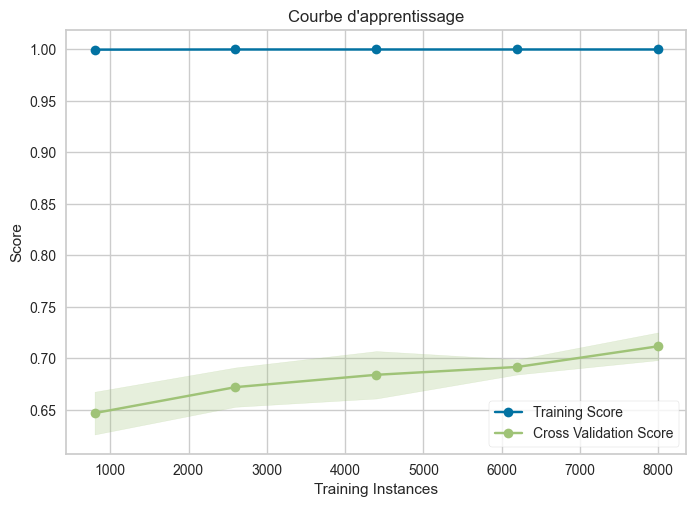

<Axes: title={'center': "Courbe d'apprentissage"}, xlabel='Training Instances', ylabel='Score'>

In [192]:
# Utilisez X_train_sub et y_train_sub dans la fonction
visualizer = LearningCurve(
    best_model_XGB_optimized, scoring='roc_auc', cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, title=f"Courbe d'apprentissage"
    )
    
# Ajustement des données au visualiseur
visualizer.fit(X_train_sub, y_train_sub)
    
# Affichage du graphique
visualizer.show()

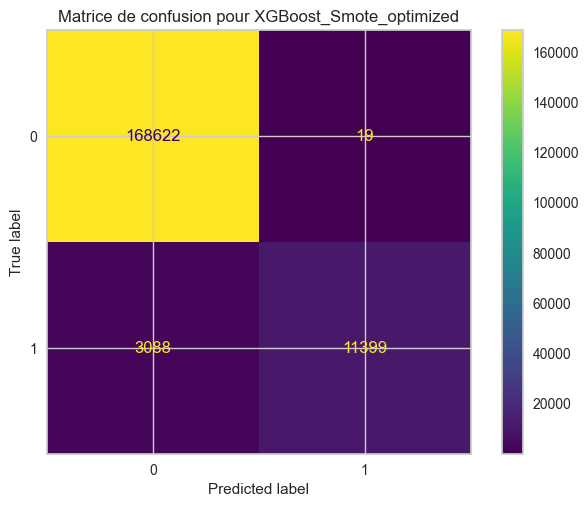

None


<Figure size 800x550 with 0 Axes>

In [193]:
confusion_matrix_train_XGB_optimized = confusion_matrix_plot(y_train, y_pred_train_XGB_optimized, name_XGB_optimized)
print(confusion_matrix_train_XGB_optimized)

ROC AUC Score for XGBoost_Smote_optimized: 1.00


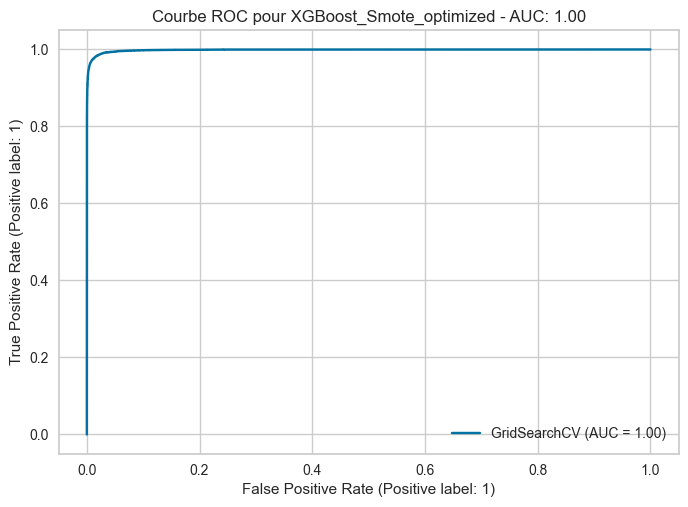

In [194]:
roc_auc_train_XGB_optimized  =roc_auc_plot(grid_search_XGB_optimized, X_train, y_train, name_XGB_optimized)

**Les résultats sont très bons (accuracy élevé, score métier faible, ROC_AUC élevé) mais vérifions ces résultats sur le jeu de test :**

In [195]:
start_test_time_XGB_optimized = time.time()
y_pred_test_XGB_optimized = best_model_XGB_optimized.predict(X_test)
test_time_XGB_optimized = time.time() - start_test_time_XGB_optimized

In [196]:
test_time_XGB_optimized

0.408292293548584

In [197]:
y_proba_test_XGB_optimized = best_model_XGB_optimized.predict_proba(X_test)[:, 1] 
metrics_test_XGB_optimized = metrics_weighted(y_test, y_pred_test_XGB_optimized, y_proba_test_XGB_optimized)
metrics_test_XGB_optimized

{'accuracy': 0.91,
 'recall weighted': 0.91,
 'precision weighted': 0.88,
 'F1 score weighted': 0.89,
 'ROC_AUC': 0.72,
 'score métier': 0.74}

In [198]:
pd.DataFrame([metrics_test_XGB_optimized])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.91,0.91,0.88,0.89,0.72,0.74


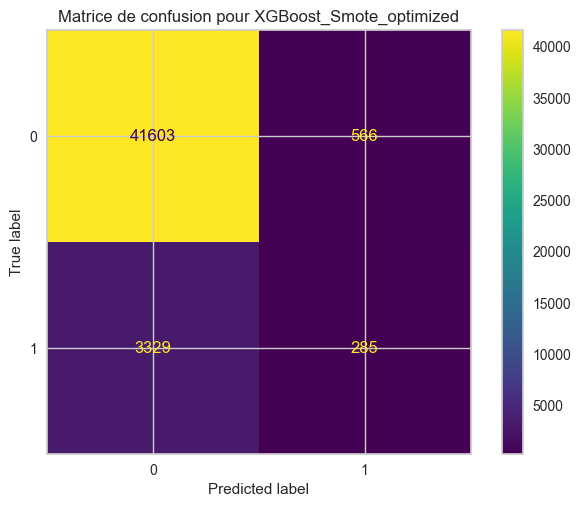

None


<Figure size 800x550 with 0 Axes>

In [199]:
confusion_matrix_XGB_optimized = confusion_matrix_plot(y_test, y_pred_test_XGB_optimized, name_XGB_optimized)
print(confusion_matrix_XGB_optimized)


ROC AUC Score for XGBoost_Smote_optimized: 0.72


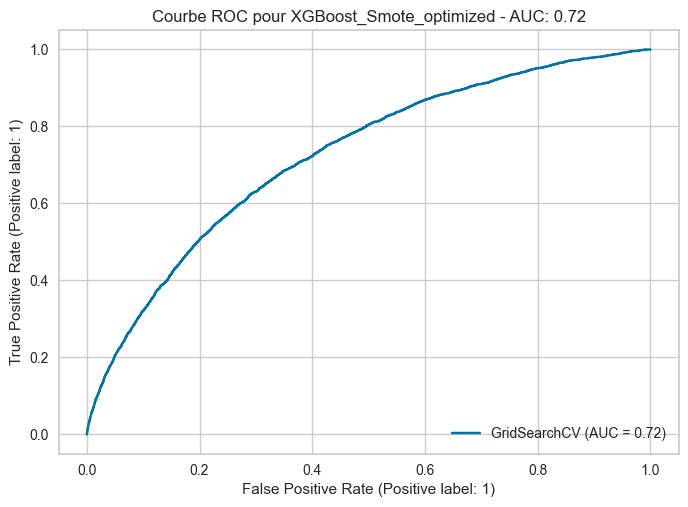

In [200]:
roc_auc_test_XGB_optimized = roc_auc_plot(grid_search_XGB_optimized, X_test, y_test, name_XGB_optimized)
roc_auc_test_XGB_optimized

In [201]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_XGB_optimized))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     42169
         1.0       0.33      0.08      0.13      3614

    accuracy                           0.91     45783
   macro avg       0.63      0.53      0.54     45783
weighted avg       0.88      0.91      0.89     45783



**Les résultats ne sont pas conservés sur le jeu de test.**

In [202]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_XGB_optimized, name_XGB_optimized, metrics_test_XGB_optimized, fit_time_train_XGB_optimized,test_time_XGB_optimized, 'Matrice_de_confusion_pour_XGBoost_Smote_optimized.png', 'roc_auc_curve_XGBoost_Smote_optimized.png', run_params=run_params_XGB_optimized)

Run - XGBoost_Smote_optimized est enregistré dans l'Expérience - modele_de_scoring


**LGBMClassifier avec balanced classs au lieu de smote**

In [203]:
name_LGBM_balanced = 'LGBMClassifier_balanced'

In [204]:
classifier_LGBM_balanced  = LGBMClassifier(objective='binary', class_weight = 'balanced')

In [205]:
pipeline_LGBM_balanced = Pipeline(steps = [['scaler', RobustScaler()], 
                                ['classifier', classifier_LGBM_balanced]])

In [206]:
param_grid_LGBM_balanced = {}
grid_search_LGBM_balanced = GridSearchCV(estimator=pipeline_LGBM_balanced,
                           param_grid=param_grid_LGBM_balanced,
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [207]:
grid_search_LGBM_balanced.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14487, number of negative: 168641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.391486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44910
[LightGBM] [Info] Number of data points in the train set: 183128, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['scaler', RobustScaler()],
                                       ['classifier',
                                        LGBMClassifier(class_weight='balanced',
                                                       objective='binary')]]),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [208]:
best_model_LGBM_balanced=grid_search_LGBM_balanced.best_estimator_

In [209]:
y_pred_train_LGBM_balanced = best_model_LGBM_balanced.predict(X_train)
fit_time_train_LGBM_balanced = grid_search_LGBM_balanced.cv_results_['mean_fit_time']
fit_time_train_LGBM_balanced

array([27.44643847])

In [210]:
y_proba_train_LGBM_balanced = best_model_LGBM_balanced.predict_proba(X_train)[:, 1] 
metrics_train_LGBM_balanced= metrics_weighted(y_train, y_pred_train_LGBM_balanced, y_proba_train_LGBM_balanced)
metrics_train_LGBM_balanced

{'accuracy': 0.75,
 'recall weighted': 0.75,
 'precision weighted': 0.91,
 'F1 score weighted': 0.8,
 'ROC_AUC': 0.84,
 'score métier': 0.41}

In [211]:
pd.DataFrame([metrics_train_LGBM_balanced])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.75,0.75,0.91,0.8,0.84,0.41


**Nous obtenons ainsi des meilleurs scores avec un score métier plus faible et un ROC_AUC plus élevé avec le paramètre class_weight = 'balanced'" qu'avec le SMOTE.**

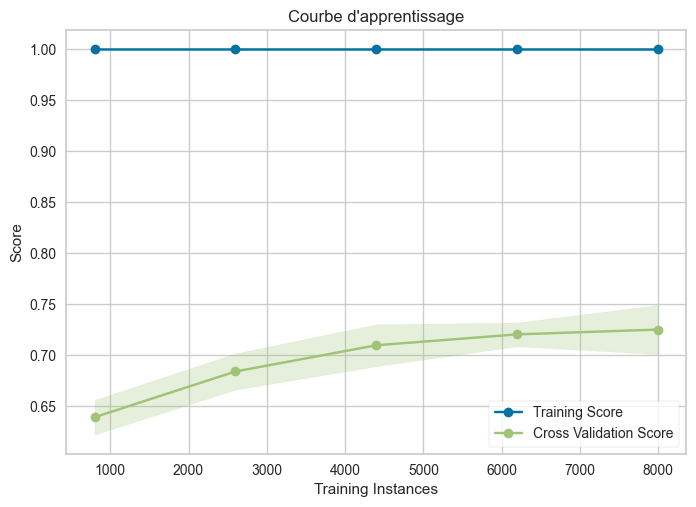

<Axes: title={'center': "Courbe d'apprentissage"}, xlabel='Training Instances', ylabel='Score'>

In [212]:
X_train_sub = X_train[:10000]  
y_train_sub = y_train[:10000]
# Utilisez X_train_sub et y_train_sub dans la fonction
visualizer = LearningCurve(
    best_model_LGBM_balanced, scoring='roc_auc', cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, title=f"Courbe d'apprentissage"
    )
    
# Ajustement des données au visualiseur
visualizer.fit(X_train_sub, y_train_sub)
    
# Affichage du graphique
visualizer.show()

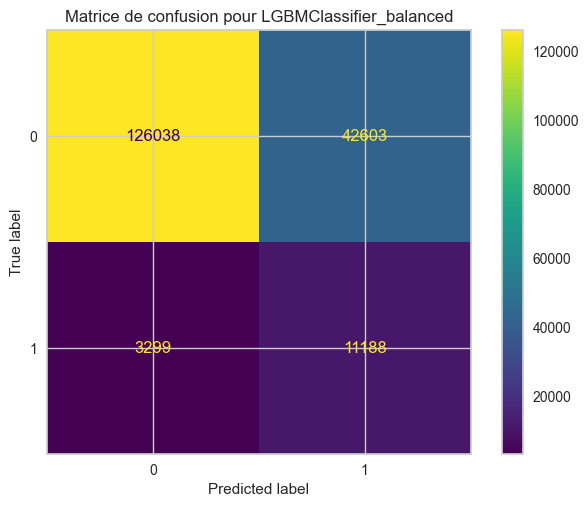

None


<Figure size 800x550 with 0 Axes>

In [213]:
confusion_matrix_train_LGBM_balanced = confusion_matrix_plot(y_train, y_pred_train_LGBM_balanced, name_LGBM_balanced)
print(confusion_matrix_train_LGBM_balanced)

ROC AUC Score for LGBMClassifier_balanced: 0.84


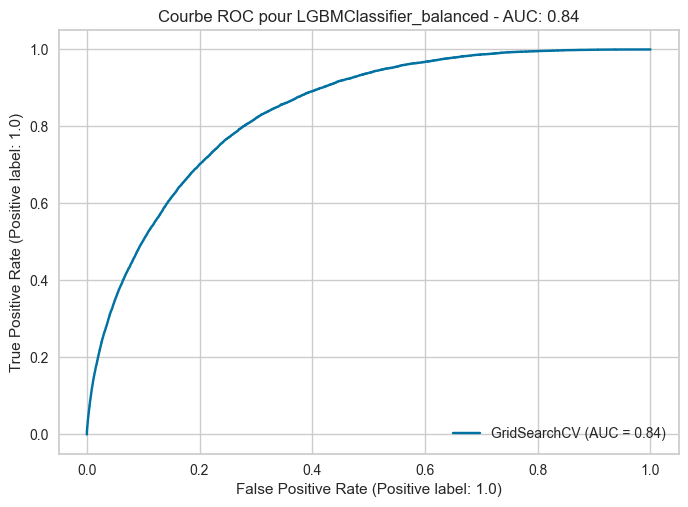

In [214]:
roc_auc_train_LGBM_balanced   =roc_auc_plot(grid_search_LGBM_balanced , X_train, y_train, name_LGBM_balanced )

In [215]:
start_test_time_LGBM_balanced = time.time()
y_pred_test_LGBM_balanced = best_model_LGBM_balanced.predict(X_test)
test_time_LGBM_balanced = time.time() - start_test_time_LGBM_balanced

In [216]:
test_time_LGBM_balanced

0.3343968391418457

In [217]:
y_proba_test_LGBM_balanced = best_model_LGBM_balanced.predict_proba(X_test)[:, 1] 
metrics_test_LGBM_balanced = metrics_weighted(y_test, y_pred_test_LGBM_balanced, y_proba_test_LGBM_balanced)
metrics_test_LGBM_balanced

{'accuracy': 0.73,
 'recall weighted': 0.73,
 'precision weighted': 0.9,
 'F1 score weighted': 0.79,
 'ROC_AUC': 0.77,
 'score métier': 0.51}

In [218]:
pd.DataFrame([metrics_test_LGBM_balanced])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.73,0.73,0.9,0.79,0.77,0.51


**Les résultats sont également plutôt bons pour le jeu de test. Nous retenons ce modèle pour lequel nous allons donc optimiser les hyperparamètres.**

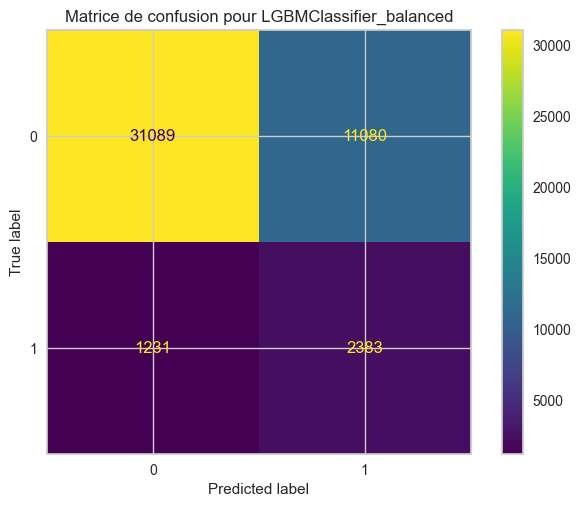

None


<Figure size 800x550 with 0 Axes>

In [219]:
confusion_matrix_LGBM_balanced = confusion_matrix_plot(y_test, y_pred_test_LGBM_balanced, name_LGBM_balanced)
print(confusion_matrix_LGBM_balanced)


ROC AUC Score for LGBMClassifier_balanced: 0.77


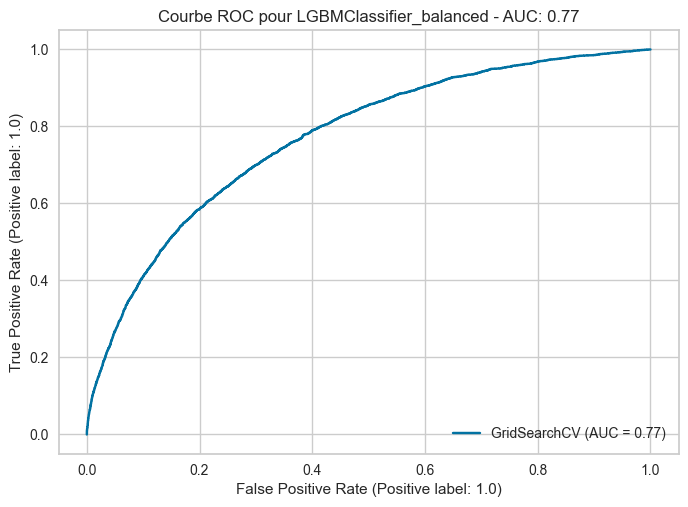

In [220]:
roc_auc_test_LGBM_balanced= roc_auc_plot(grid_search_LGBM_balanced, X_test, y_test, name_LGBM_balanced)
roc_auc_test_LGBM_balanced

In [221]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_LGBM_balanced))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     42169
         1.0       0.18      0.66      0.28      3614

    accuracy                           0.73     45783
   macro avg       0.57      0.70      0.56     45783
weighted avg       0.90      0.73      0.79     45783



In [222]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_LGBM_balanced, name_LGBM_balanced, metrics_test_LGBM_balanced, fit_time_train_LGBM_balanced,test_time_LGBM_balanced, 'Matrice_de_confusion_pour_LGBMClassifier_balanced.png', 'roc_auc_curve_LGBMClassifier_balanced.png', run_params=None)

Run - LGBMClassifier_balanced est enregistré dans l'Expérience - modele_de_scoring


**LGBMClassifier optimisé**

In [223]:
name_LGBM_optimized = 'LGBMClassifier_optimized'

In [224]:
classifier_LGBM_optimized = LGBMClassifier(objective='binary', class_weight = 'balanced')

In [225]:
pipeline_LGBM_optimized = Pipeline(steps = [['scaler', RobustScaler()], 
                                ['classifier', classifier_LGBM_optimized]])

In [226]:
param_grid_LGBM_optimized = {'classifier__num_leaves':[30], #[50, 60, 70],
            'classifier__colsample_bytree': [0.8],#[0.4, 0.6, 0.8],
            'classifier__subsample': [0.9],#[0.3, 0.4, 0.5],
            'classifier__reg_alpha' : [0.1], #[0, 0.1, 0.2],
            'classifier__reg_lambda' : [0.1] #[0, 0.1, 0.2]
            }

In [227]:
grid_search_LGBM_optimized = GridSearchCV(estimator=pipeline_LGBM_optimized,
                           param_grid=param_grid_LGBM_optimized,
                           scoring=business_scorer_obj,
                           cv=stratified_kfold,
                           n_jobs=-1)

In [228]:
grid_search_LGBM_optimized.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14487, number of negative: 168641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.411725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44910
[LightGBM] [Info] Number of data points in the train set: 183128, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['scaler', RobustScaler()],
                                       ['classifier',
                                        LGBMClassifier(class_weight='balanced',
                                                       objective='binary')]]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8],
                         'classifier__num_leaves': [30],
                         'classifier__reg_alpha': [0.1],
                         'classifier__reg_lambda': [0.1],
                         'classifier__subsample': [0.9]},
             scoring=make_scorer(business_scorer, greater_is_better=False))

In [229]:
best_model_LGBM_optimized=grid_search_LGBM_optimized.best_estimator_

In [230]:
run_params_LGBM_optimized = grid_search_LGBM_optimized.best_params_

In [231]:
run_params_LGBM_optimized

{'classifier__colsample_bytree': 0.8,
 'classifier__num_leaves': 30,
 'classifier__reg_alpha': 0.1,
 'classifier__reg_lambda': 0.1,
 'classifier__subsample': 0.9}

In [232]:
y_pred_train_LGBM_optimized = best_model_LGBM_optimized.predict(X_train)
fit_time_train_LGBM_optimized = grid_search_LGBM_optimized.cv_results_['mean_fit_time']
fit_time_train_LGBM_optimized

array([21.29903372])

In [233]:
y_proba_train_LGBM_optimized = best_model_LGBM_optimized.predict_proba(X_train)[:, 1] 
metrics_train_LGBM_optimized= metrics_weighted(y_train, y_pred_train_LGBM_optimized, y_proba_train_LGBM_optimized)
metrics_train_LGBM_optimized

{'accuracy': 0.75,
 'recall weighted': 0.75,
 'precision weighted': 0.91,
 'F1 score weighted': 0.8,
 'ROC_AUC': 0.84,
 'score métier': 0.42}

In [234]:
pd.DataFrame([metrics_train_LGBM_optimized])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.75,0.75,0.91,0.8,0.84,0.42


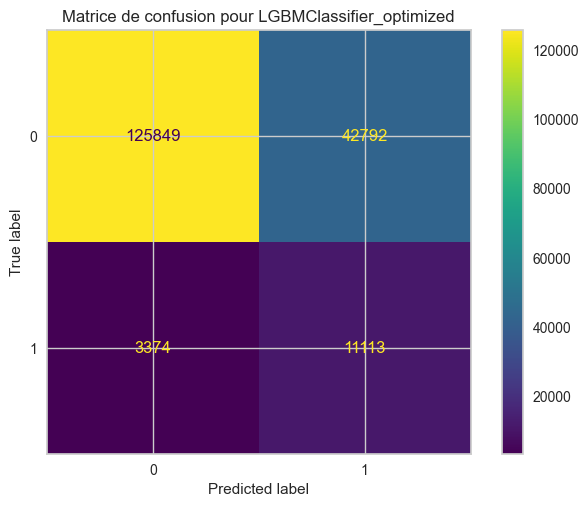

None


<Figure size 800x550 with 0 Axes>

In [235]:
confusion_matrix_train_LGBM_optimized = confusion_matrix_plot(y_train, y_pred_train_LGBM_optimized, name_LGBM_optimized)
print(confusion_matrix_train_LGBM_optimized)

ROC AUC Score for LGBMClassifier_optimized: 0.84


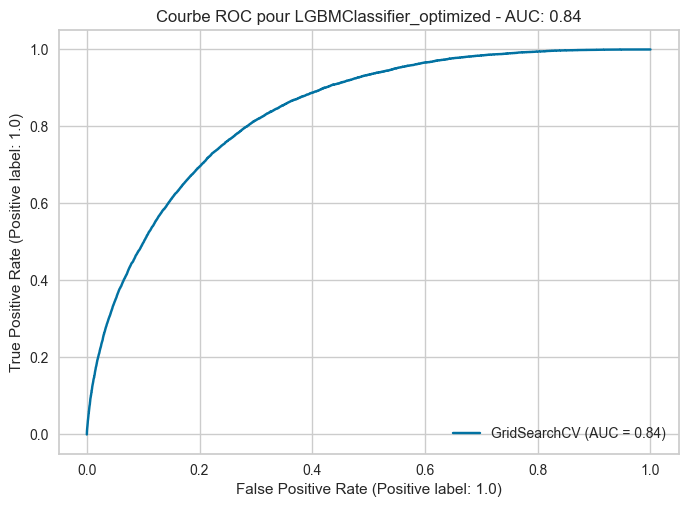

In [236]:
roc_auc_train_LGBM_optimized   =roc_auc_plot(grid_search_LGBM_optimized , X_train, y_train, name_LGBM_optimized )

In [237]:
start_test_time_LGBM_optimized = time.time()
y_pred_test_LGBM_optimized = best_model_LGBM_optimized.predict(X_test)
test_time_LGBM_optimized = time.time() - start_test_time_LGBM_optimized

In [238]:
test_time_LGBM_optimized

0.353041410446167

In [239]:
y_proba_test_LGBM_optimized = best_model_LGBM_optimized.predict_proba(X_test)[:, 1] 
metrics_test_LGBM_optimized = metrics_weighted(y_test, y_pred_test_LGBM_optimized, y_proba_test_LGBM_optimized)
metrics_test_LGBM_optimized

{'accuracy': 0.73,
 'recall weighted': 0.73,
 'precision weighted': 0.9,
 'F1 score weighted': 0.79,
 'ROC_AUC': 0.77,
 'score métier': 0.5}

In [240]:
pd.DataFrame([metrics_test_LGBM_optimized])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.73,0.73,0.9,0.79,0.77,0.5


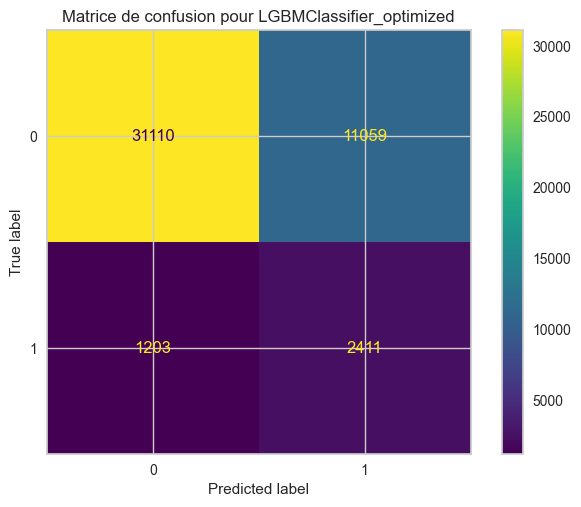

None


<Figure size 800x550 with 0 Axes>

In [241]:
confusion_matrix_LGBM_optimized= confusion_matrix_plot(y_test, y_pred_test_LGBM_optimized, name_LGBM_optimized)
print(confusion_matrix_LGBM_optimized)

ROC AUC Score for LGBMClassifier_optimized: 0.77


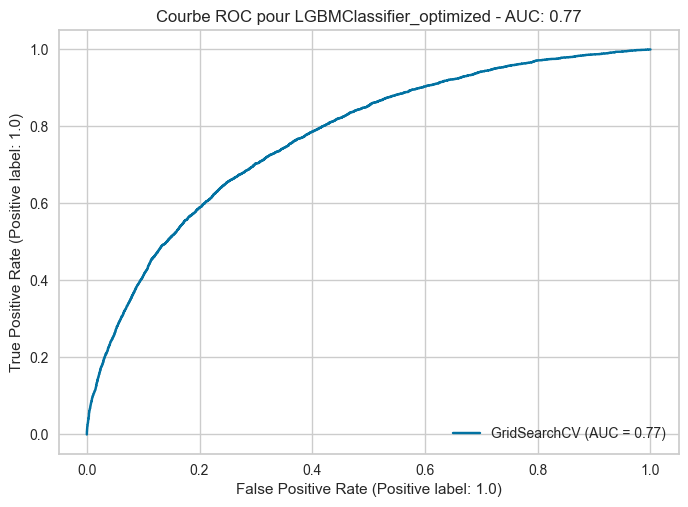

In [242]:
roc_auc_test_LGBM_optimized= roc_auc_plot(grid_search_LGBM_optimized, X_test, y_test, name_LGBM_optimized)
roc_auc_test_LGBM_optimized

In [243]:
from sklearn.metrics import classification_report
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_LGBM_optimized))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     42169
         1.0       0.18      0.67      0.28      3614

    accuracy                           0.73     45783
   macro avg       0.57      0.70      0.56     45783
weighted avg       0.90      0.73      0.79     45783



In [244]:
# Enregistré le model sur MLFLOW
log_mlflow(grid_search_LGBM_optimized, name_LGBM_optimized, metrics_test_LGBM_optimized, fit_time_train_LGBM_optimized,test_time_LGBM_optimized, 'Matrice_de_confusion_pour_LGBMClassifier_optimized.png', 'roc_auc_curve_LGBMClassifier_optimized.png', run_params=None)

Run - LGBMClassifier_optimized est enregistré dans l'Expérience - modele_de_scoring


**Le score métier augmente légèrement sur le jeu de test mais reste assez faible.**

Nous retenons donc le modèle LGBM qui a les meilleurs scores. Sélectionnons maintenant 25 variables qui contribuent le plus au modèle. Il s'agit en effet de pouvoir dire facilement à un client avec quelques variables seulement si un prêt peut lui être accordé.

### <div class="alert alert-info"><font color='dimgray'>VI.Selection des variables le plus importantes. </font> </div>

In [245]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns

feature_importance["importance"] = best_model_LGBM_optimized['classifier'].feature_importances_

feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

In [246]:
feature_importance

,feature,importance
215,PAYMENT_RATE,146
25,EXT_SOURCE_2,117
24,EXT_SOURCE_3,90
30,DAYS_BIRTH,75
36,DAYS_EMPLOYED,55
...,...,...
233,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,0
219,PREV_PRODUCT_COMBINATION_POS mobile with inter...,0
196,PREV_CHANNEL_TYPE_Country-wide_MEAN,0
244,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,0


<div class="alert alert-success">
    
**Choix de 20 Features seulement**
</div>

In [247]:
top_20_feature_importance = feature_importance.head(20)
top_20_feature_importance

,feature,importance
215,PAYMENT_RATE,146
25,EXT_SOURCE_2,117
24,EXT_SOURCE_3,90
30,DAYS_BIRTH,75
36,DAYS_EMPLOYED,55
204,AMT_ANNUITY,50
135,INSTAL_AMT_PAYMENT_MIN,49
124,AMT_CREDIT,46
92,PREV_CNT_PAYMENT_MEAN,44
242,INSTAL_DAYS_ENTRY_PAYMENT_MAX,39


In [248]:
features_selected = feature_importance.head(20)['feature'].to_list()

In [249]:
features_selected

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_PAYMENT_MIN',
 'AMT_CREDIT',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'AMT_GOODS_PRICE',
 'CODE_GENDER_M',
 'APPROVED_CNT_PAYMENT_MEAN',
 'ANNUITY_INCOME_PERC',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'POS_MONTHS_BALANCE_SIZE']

### <div class="alert alert-info"><font color='dimgray'>VI.1 .Evaluation du modèle avec les 20 features sélectionnés. </font> </div>

In [250]:
name_LGBM_features_selected= 'LGBMClassifier_features_selected'

In [251]:
best_model_LGBM_optimized.fit(X_train[features_selected], y_train)

[LightGBM] [Info] Number of positive: 14487, number of negative: 168641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4702
[LightGBM] [Info] Number of data points in the train set: 183128, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('scaler', RobustScaler()),
                ['classifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                num_leaves=30, objective='binary',
                                reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.9)]])

In [252]:
y_pred_train_LGBM_features_selected = best_model_LGBM_optimized.predict(X_train[features_selected])

In [253]:
y_proba_train_LGBM_features_selected = best_model_LGBM_optimized.predict_proba(X_train[features_selected])[:, 1] 
metrics_train_LGBM_features_selected= metrics_weighted(y_train, y_pred_train_LGBM_features_selected, y_proba_train_LGBM_features_selected)
metrics_train_LGBM_features_selected

{'accuracy': 0.72,
 'recall weighted': 0.72,
 'precision weighted': 0.91,
 'F1 score weighted': 0.79,
 'ROC_AUC': 0.81,
 'score métier': 0.46}

In [254]:
pd.DataFrame([metrics_train_LGBM_features_selected])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.72,0.72,0.91,0.79,0.81,0.46


**nous perdons 0.1 d'accuracy et prenons 0.05 points métier en diminuant le nombre de variables à 20**

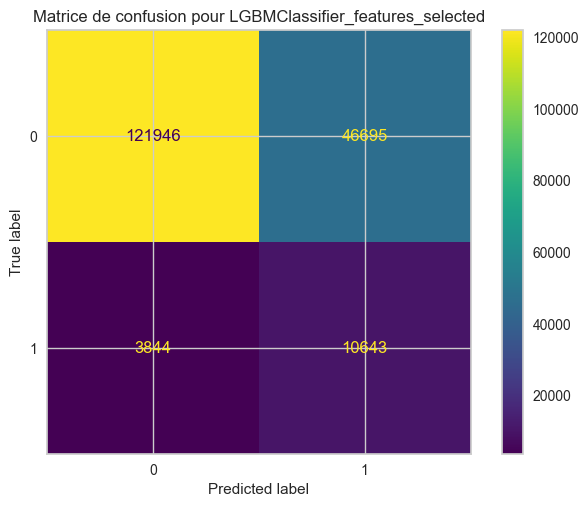

None


<Figure size 800x550 with 0 Axes>

In [255]:
confusion_matrix_train_LGBM_features_selected = confusion_matrix_plot(y_train, y_pred_train_LGBM_features_selected, name_LGBM_features_selected)
print(confusion_matrix_train_LGBM_features_selected)

ROC AUC Score for LGBMClassifier_features_selected: 0.81


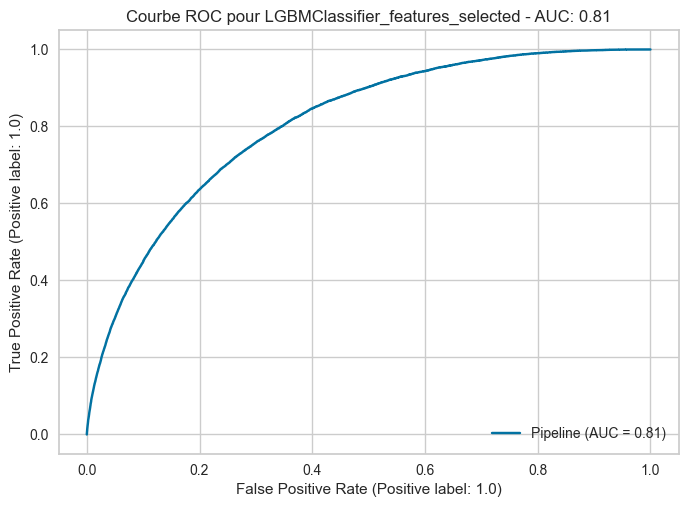

In [256]:
roc_auc_train_LGBM_features_selected   =roc_auc_plot(best_model_LGBM_optimized , X_train[features_selected], y_train, name_LGBM_features_selected )

In [257]:
start_test_time_LGBM_features_selected  = time.time()
y_pred_test_LGBM_features_selected  = best_model_LGBM_optimized.predict(X_test[features_selected])
test_time_LGBM_features_selected  = time.time() - start_test_time_LGBM_features_selected

In [258]:
test_time_LGBM_features_selected

0.13705182075500488

In [259]:
y_proba_test_LGBM_features_selected  = best_model_LGBM_optimized.predict_proba(X_test[features_selected])[:, 1] 
metrics_test_LGBM_features_selected  = metrics_weighted(y_test, y_pred_test_LGBM_features_selected, y_proba_test_LGBM_features_selected)
metrics_test_LGBM_features_selected 

{'accuracy': 0.71,
 'recall weighted': 0.71,
 'precision weighted': 0.9,
 'F1 score weighted': 0.78,
 'ROC_AUC': 0.76,
 'score métier': 0.53}

In [260]:
pd.DataFrame([metrics_test_LGBM_features_selected])

,accuracy,recall weighted,precision weighted,F1 score weighted,ROC_AUC,score métier
0,0.71,0.71,0.9,0.78,0.76,0.53


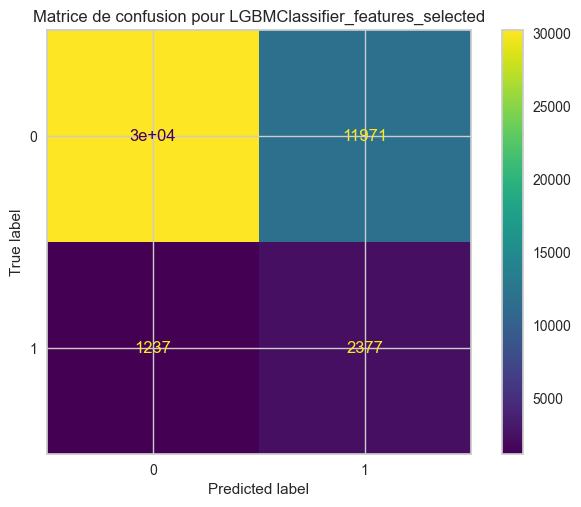

None


<Figure size 800x550 with 0 Axes>

In [261]:
confusion_matrix_LGBM_features_selected= confusion_matrix_plot(y_test, y_pred_test_LGBM_features_selected, name_LGBM_features_selected)
print(confusion_matrix_LGBM_features_selected)


ROC AUC Score for LGBMClassifier_features_selected: 0.76


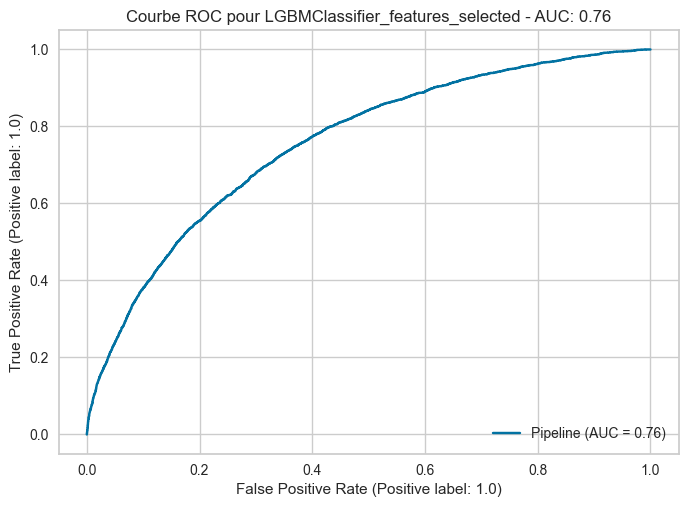

In [262]:
roc_auc_test_LGBM_features_selected= roc_auc_plot(best_model_LGBM_optimized, X_test[features_selected], y_test, name_LGBM_features_selected)
roc_auc_test_LGBM_features_selected

In [263]:
# Générer et afficher le rapport de classification
print(classification_report(y_test, y_pred_test_LGBM_features_selected))

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     42169
         1.0       0.17      0.66      0.26      3614

    accuracy                           0.71     45783
   macro avg       0.56      0.69      0.54     45783
weighted avg       0.90      0.71      0.78     45783



In [264]:
# MLFLOW pour le best model
def mlflow_best_model(model, name, run_metrics, run_params=None):
    mlflow.set_experiment("Best_model_selected_features")

    # track params and metrics
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)
        
        # Set parameters
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
                
        # Set metrics    
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
            
        
        # log model
        mlflow.sklearn.log_model(model, name)
        
    print('Run - %s is logged to Experiment - %s' %(name, "Best_model_selected_features"))


In [265]:
mlflow_best_model(best_model_LGBM_optimized, name_LGBM_features_selected, metrics_test_LGBM_features_selected, run_params=run_params_LGBM_optimized)

Run - LGBMClassifier_features_selected is logged to Experiment - Best_model_selected_features


### <div class="alert alert-info"><font color='dimgray'>VI.2 .Sérialiser le model à l'aide de pickle. </font> </div>

In [266]:
# la liste des étapes (nom et estimateur/transformateur)
best_model_LGBM_optimized.steps

[('scaler', RobustScaler()),
 ['classifier',
  LGBMClassifier(class_weight='balanced', colsample_bytree=0.8, num_leaves=30,
                 objective='binary', reg_alpha=0.1, reg_lambda=0.1,
                 subsample=0.9)]]

In [267]:
LGBM_model=best_model_LGBM_optimized

In [268]:
LGBM_model

Pipeline(steps=[('scaler', RobustScaler()),
                ['classifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                num_leaves=30, objective='binary',
                                reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.9)]])

In [269]:
# Serialisation de model
filename = 'C:/Users/belaziw/Desktop/Dossier_Alternance_BELAZI-Walid/Librable_Projet_OpenClassRooms/Projet 7/Notebooks/api/lgbm_classifier.pkl'
pickle.dump(LGBM_model, open(filename, 'wb'))

**Notre modèle enregistré est un pipeline qui contient déjà le **RobustScaler** ainsi qu'un classificateur (LGBMClassifier)**

### <div class="alert alert-info"><font color='dimgray'>VII .Ajustement de seuil métier (seuil de décision) </font> </div>

<div class="alert alert-success">
    
Un seuil métier est une valeur spécifique utilisée pour décider de la classe à attribuer à une prédiction basée sur une probabilité.

Par défaut, **un seuil de 0,5** est couramment utilisé pour classifier une observation comme appartenant à la classe positive (si la probabilité prédite est supérieure ou égale à 0,5) ou à la classe négative (si elle est inférieure à 0,5).

Cependant, ce seuil de 0,5 n'est pas toujours optimal pour toutes les situations d'entreprise ou tous les ensembles de données.
</div>

**Méthode 1:  Seuil optimal en analysant la courbe ROC (Receiver Operating Characteristic)**

In [270]:
# Calcul des probabilités de prédiction
y_pred_proba_test_lgbm_features_reduced = best_model_LGBM_optimized.predict_proba(X_test[features_selected])[:, 1]

In [271]:
# Calcul de la courbe ROC et de l'aire sous la courbe (AUC)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_lgbm_features_reduced)
roc_auc = auc(fpr, tpr)

In [272]:
# Trouver le seuil le plus proche d'un point spécifique, ici en maximisant tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = round(thresholds[optimal_idx],2)

In [273]:
optimal_threshold

0.48

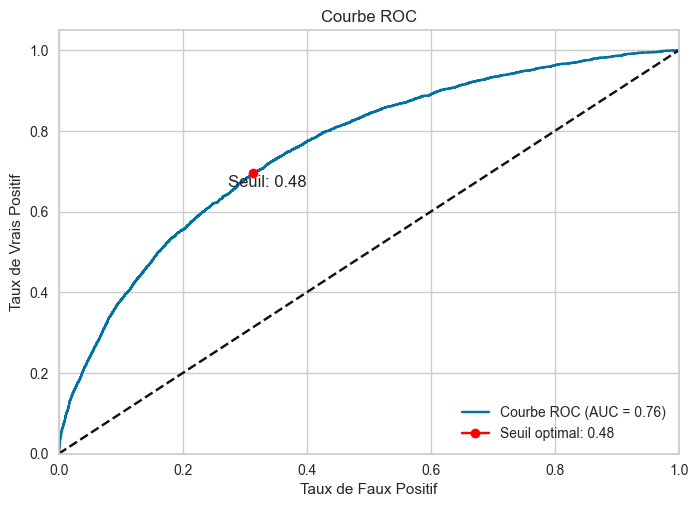

In [274]:
# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrais Positif')
plt.title('Courbe ROC')

# Ajouter un point pour le seuil optimal
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Seuil optimal: {optimal_threshold:.2f}')
plt.annotate(f"Seuil: {optimal_threshold:.2f}", (fpr[optimal_idx], tpr[optimal_idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.legend(loc='lower right')
plt.show()

**Méthode 1: Minimisation de la fonction cout**

In [275]:
moyenne_credit = X_train['AMT_CREDIT'].mean()

In [276]:
round(moyenne_credit,2)

604580.65

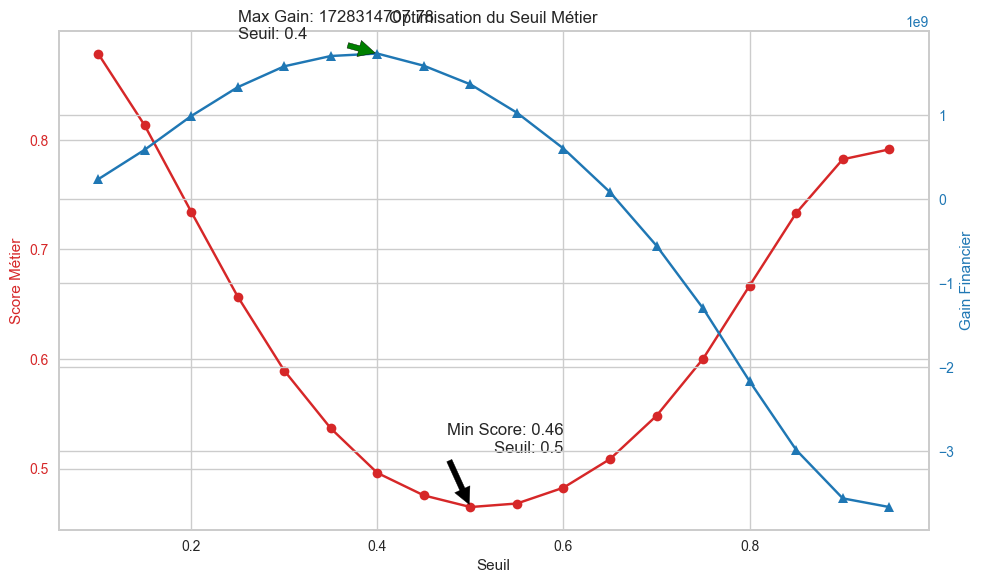

In [277]:
# Définition des seuils à tester
thresholds = [x / 100 for x in range(10, 100, 5)]
faux_neg = []
gain = []
score_metier = []
roc_auc = []

# Boucle pour calculer les métriques à chaque seuil
for thd in thresholds:
    # Prédiction binaire basée sur le seuil courant
    y_pred = (best_model_LGBM_optimized.predict_proba(X_train[features_selected])[:, 1] >= thd).astype(int)
    
    # Calcul de la matrice de confusion et extraction des TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    
    # Ajout du nombre de faux négatifs à la liste pour affichage
    faux_neg.append(fn)
    
    # Calcul du gain financier basé sur le taux d'intérêt et la moyenne des crédits
    gain_financier = (0.05 * moyenne_credit) * tn - moyenne_credit * fn
    gain.append(gain_financier)
    
    # Calcul du score métier
    score_metier.append(business_scorer(y_train, y_pred))
    
    # Calcul et stockage du score ROC AUC
    roc_auc.append(roc_auc_score(y_train, y_pred))

# Identification du seuil avec le score métier minimal et le gain financier maximal
min_score_idx = np.argmin(score_metier)
min_score_threshold = thresholds[min_score_idx]
max_gain_idx = np.argmax(gain)
max_gain_threshold = thresholds[max_gain_idx]

# Préparation du graphique
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Seuil')
ax1.set_ylabel('Score Métier', color=color)
ax1.plot(thresholds, score_metier, color=color, label='Score Métier', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Annotation pour le score métier minimal
ax1.annotate(f'Min Score: {score_metier[min_score_idx]:.2f}\nSeuil: {min_score_threshold}', 
             xy=(min_score_threshold, score_metier[min_score_idx]), 
             xytext=(min_score_threshold+0.1, score_metier[min_score_idx] + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('Gain Financier', color=color)
ax2.plot(thresholds, gain, color=color, label='Gain Financier', marker='^')
ax2.tick_params(axis='y', labelcolor=color)

# Annotation pour le gain financier maximal
ax2.annotate(f'Max Gain: {gain[max_gain_idx]:.2f}\nSeuil: {max_gain_threshold}', 
             xy=(max_gain_threshold, gain[max_gain_idx]), 
             xytext=(max_gain_threshold-0.15, gain[max_gain_idx] + 0.1 * max(gain)),
             arrowprops=dict(facecolor='green', shrink=0.05),
             horizontalalignment='left')

fig.tight_layout()
plt.title('Optimisation du Seuil Métier')
plt.show()


<div class="alert alert-success">
    
Nous sommes confronté à des résultats différents selon la méthode utilisée pour déterminer le seuil optimal de notre modèle de classification, le choix du seuil à utiliser doit être guidé par les objectifs spécifiques et les contraintes de notre application métier. 

Voici quelques considérations pour nous aider à prendre une décision :

**1. Priorités Métier**

**Importance du Gain Financier :** Si l'objectif principal de notre modèle est de maximiser le gain financier, le seuil de 0.4, qui maximise ce gain, pourrait être le choix préféré.

**2. Considérations sur les Coûts**

**Coûts des Erreurs :** Le seuil qui minimise le score métier (0.5) reflète un équilibre entre les différents types d'erreurs selon la fonction de coût métier spécifiée. Alors le seuil de 0.5 pourrait être justifié même s'il n'optimise pas directement le gain financier.

**3. Sensibilité et Spécificité**

**Impact sur la Sensibilité et la Spécificité :** Le seuil de 0.45 obtenu par la méthode de la courbe ROC peut offrir un compromis intéressant entre sensibilité (vrais positifs) et spécificité (vrais négatifs), mais sans prendre en compte directement les coûts ou gains financiers. 
</div>

### <div class="alert alert-info"><font color='dimgray'>VII.1 .Test et Validation </font> </div>

In [279]:
# Seuils à évaluer
thresholds = [0.4, 0.48, 0.5]

# Initialisation des listes pour stocker les résultats
results = []

for thd in thresholds:
    # Prédiction de probabilités pour l'ensemble de test
    y_pred_proba = best_model_LGBM_optimized.predict_proba(X_test[features_selected])[:, 1]
    # Conversion des probabilités en décisions binaires basées sur le seuil
    y_pred = (y_pred_proba >= thd).astype(int)
    
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calcul du gain financier pour ce seuil
    gain_financier = (0.05 * moyenne_credit) * tn - moyenne_credit * fn
    
    # Calcul du score métier pour ce seuil
    score_metier = business_scorer(y_test, y_pred)
    
    # Calcul du score ROC AUC pour ce seuil
    roc_auc = roc_auc_score(y_test, y_pred_proba)  # Note: ROC AUC utilise les probabilités, pas les prédictions binaires
    
    # Ajout des résultats dans la liste
    results.append((thd, gain_financier, score_metier, roc_auc))

# Affichage des résultats
print("Seuil\tGain Financier\tScore Métier\tROC AUC")
for res in results:
    print(f"{res[0]}\t{res[1]:.2f}\t\t{res[2]:.2f}\t\t{res[3]:.2f}")


Seuil	Gain Financier	Score Métier	ROC AUC
0.4	281341606.07		0.55		0.76
0.48	199692989.11		0.53		0.76
0.5	164990059.73		0.53		0.76


**Analyse des Résultats**

<div class="alert alert-success">
    
**ROC AUC :** 

La valeur constante de 0.77 pour le ROC AUC à travers les différents seuils indique que la capacité globale de notre modèle à distinguer entre les classes positives et négatives reste inchangée quel que soit le seuil. 

**Gain Financier :** 

Le gain financier diminue avec l'augmentation du seuil, ce qui indique que fixer le seuil à une valeur plus basse (0.4) maximise le gain financier. 


**Score Métier :** 
Le score métier s'améliore  à mesure que le seuil augmente. Cela suggère que le seuil de 0.5 est plus efficace pour optimiser les objectifs métier.
</div>

**Notre choix**

<div class="alert alert-success">
    
**Choix Basé sur le Gain Financier :** le gain financier est notre priorité absolue, un seuil de **0.4** semble être le meilleur choix, car il maximise le gain financier.
</div>

### <div class="alert alert-info"><font color='dimgray'>VIII .Interprétabilité de notre modèle  </font> </div>

<div class="alert alert-success">
    
L'interprétabilité des modèles de machine learning est cruciale pour comprendre comment les prédictions sont faites.

**- SHAP (SHapley Additive exPlanations)**

SHAP est une approche basée sur la théorie des jeux pour expliquer la sortie du modèle. Elle attribue à chaque caractéristique une importance pour une prédiction particulière, en tenant compte de l'interaction entre les caractéristiques.
</div>

### <div class="alert alert-info"><font color='dimgray'>VIII.1 Explication Globale  </font> </div>

<div class="alert alert-success">
    
L'explication globale nous donne **une vue d'ensemble** de l'importance et des effets de chaque caractéristique sur **les prédictions du modèle sur l'ensemble du jeu de données.**
</div>

In [280]:
# 1Extraire le modèle LGBMClassifier du pipeline
best_model_LGBM_optimized

Pipeline(steps=[('scaler', RobustScaler()),
                ['classifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                num_leaves=30, objective='binary',
                                reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.9)]])

In [281]:
lgbm_model = best_model_LGBM_optimized.named_steps['classifier']

In [282]:
lgbm_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8, num_leaves=30,
               objective='binary', reg_alpha=0.1, reg_lambda=0.1,
               subsample=0.9)

In [283]:
#Transformer les données de test avec le prétraitement du pipeline, sauf le classificateur
X_test_transformed = best_model_LGBM_optimized.named_steps['scaler'].transform(X_test[features_selected])

In [284]:
# Initialiser l'Explainer SHAP pour le modèle LGBM extrait
explainer = shap.Explainer(lgbm_model, X_test_transformed)

In [285]:
## Calculer les valeurs SHAP pour l'ensemble de test transformé, en ignorant la vérification d'additivité
shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)

 99%|===================| 45517/45783 [02:44<00:00]        

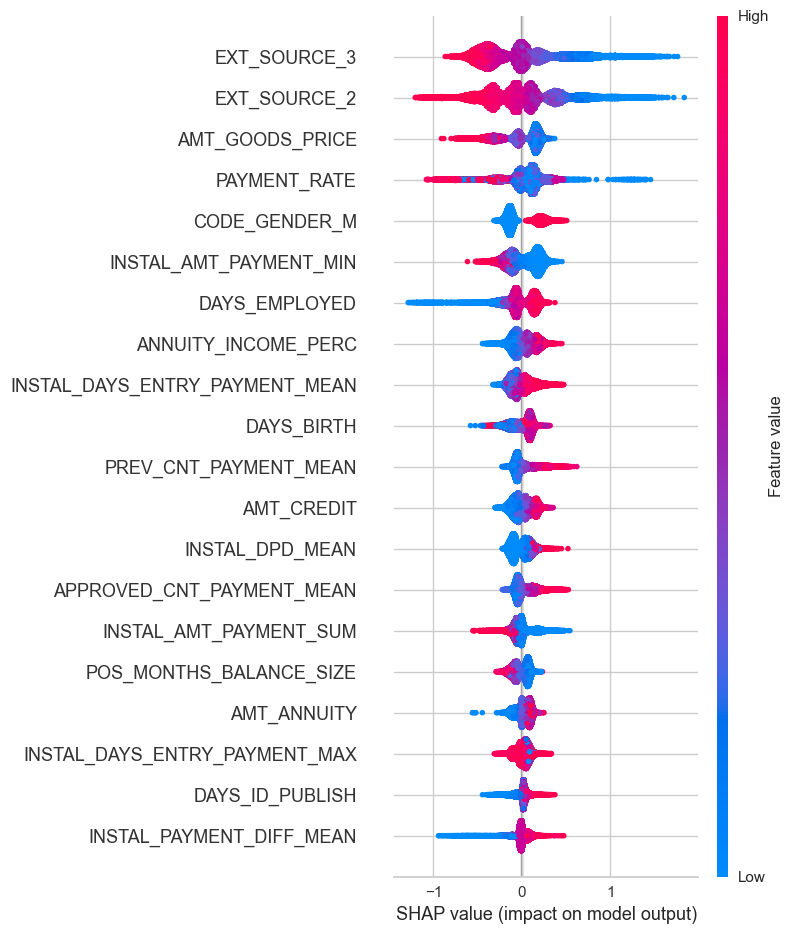

In [286]:
# Résumé graphique pour l'explication globale
shap.summary_plot(shap_values, X_test_transformed, feature_names=features_selected)

In [287]:
feature_names = X_test[features_selected].columns.tolist()

In [288]:
# Créer un DataFrame à partir de X_test_transformed pour conserver les noms des caractéristiques
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

In [289]:
# Calculer les valeurs SHAP pour l'ensemble de test transformé, avec vérification d'additivité désactivée si nécessaire
shap_values_ = explainer(X_test_transformed_df, check_additivity=False)

100%|===================| 45757/45783 [02:47<00:00]        

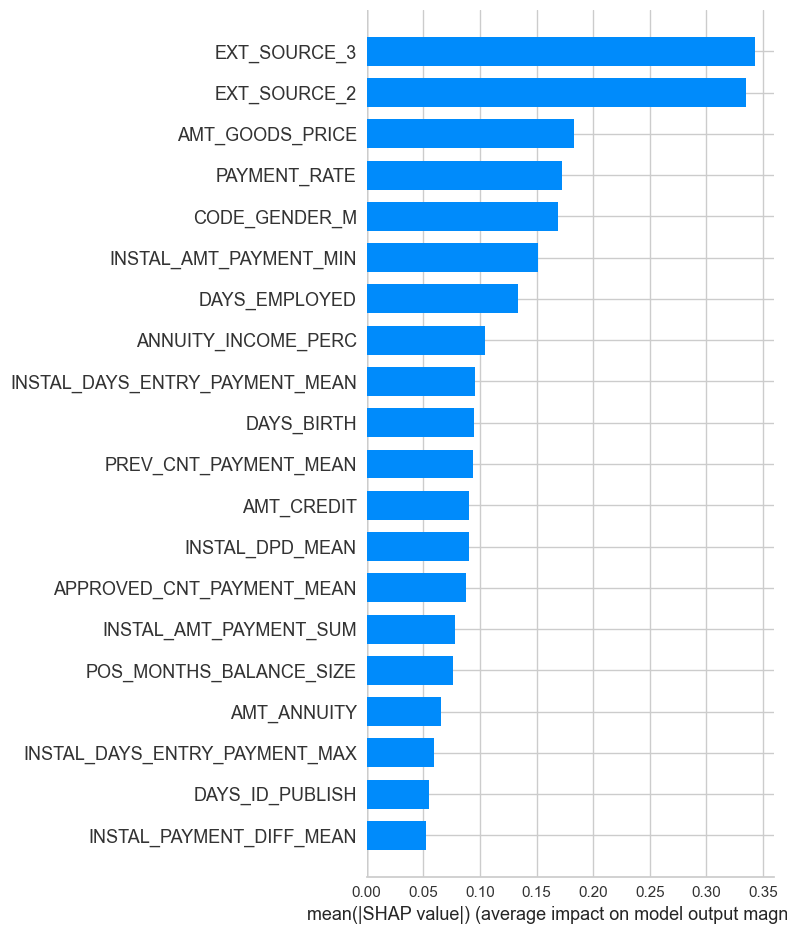

In [290]:
# Générer le graphique en barres avec les bons noms de caractéristiques
shap.summary_plot(shap_values_, X_test_transformed_df, plot_type="bar")

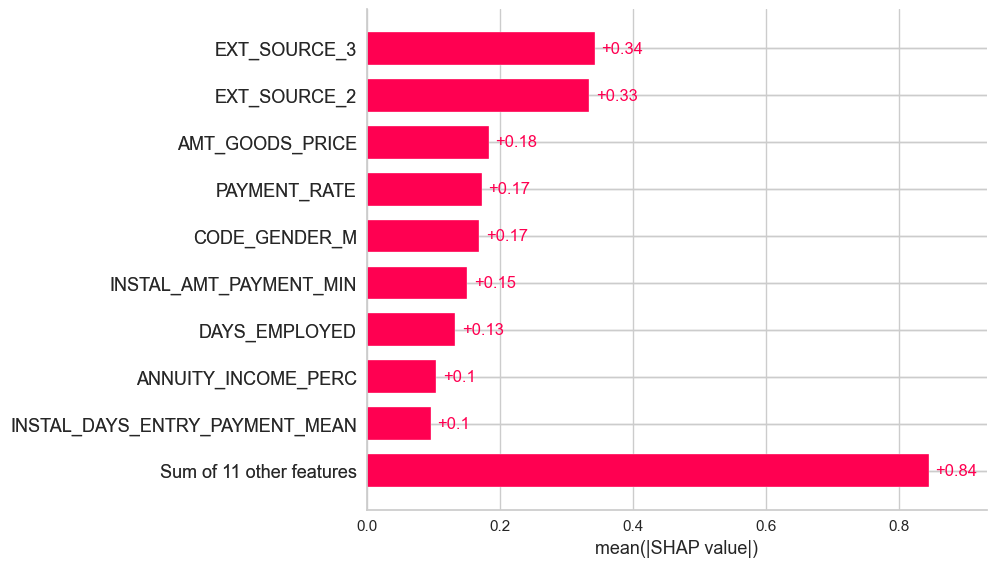

In [291]:
# Générer un graphique en barres des valeurs SHAP pour l'importance des caractéristiques globalement
shap.plots.bar(shap_values_)

### <div class="alert alert-info"><font color='dimgray'>VIII.2 Explication Locale  </font> </div>

<div class="alert alert-success">
    
**Explication Locale :** 

Montre comment chaque caractéristique a contribué à une prédiction spécifique, ce qui est utile pour comprendre le comportement du modèle sur des instances individuelles.
</div>

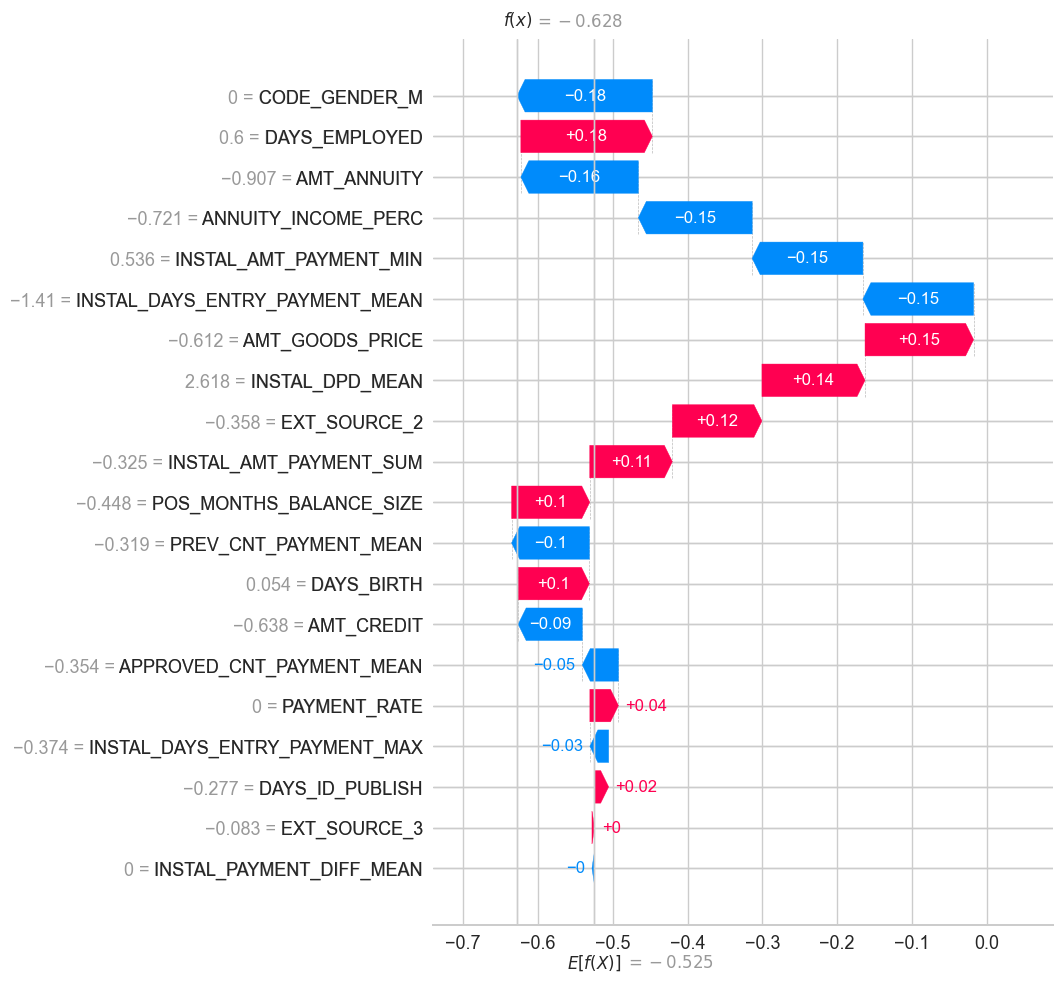

In [292]:
# Sélectionnez une instance spécifique à expliquer
# Expliquer la première instance de notre ensemble de test
instance_index = 0 

# Générer le graphique "waterfall" pour cette instance
shap.plots.waterfall(shap_values_[instance_index], max_display=20)

In [293]:
# Initialise la bibliothèque JavaScript pour SHAP
shap.initjs()
# Générer un graphique "force" pour une instance spécifique
shap.plots.force(explainer.expected_value, shap_values[instance_index], feature_names=features_selected)

### <div class="alert alert-info"><font color='dimgray'>IX. Enregistrement de jeu de données de production avec les variables sélectionnées (20 variables)  </font> </div>

In [294]:
features_selected

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_PAYMENT_MIN',
 'AMT_CREDIT',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'AMT_GOODS_PRICE',
 'CODE_GENDER_M',
 'APPROVED_CNT_PAYMENT_MEAN',
 'ANNUITY_INCOME_PERC',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'POS_MONTHS_BALANCE_SIZE']

In [338]:
df_train_prod = pd.read_csv('df_merged.csv')

In [339]:
df_train_prod.shape

(356251, 796)

In [345]:
df_train_prod.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,1,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [346]:
df_prod = df_train_prod.loc[df_train_prod['TARGET'].isna()]

In [347]:
df_prod.shape

(48744, 796)

In [348]:
df_prod=df_prod[features_selected]

In [349]:
df_prod.shape

(48744, 20)

In [350]:
test_remplissage(df_prod)

,Taux de remplissage,Nombre de valeurs manquantes
AMT_GOODS_PRICE,100.00,0
AMT_CREDIT,100.00,0
DAYS_ID_PUBLISH,100.00,0
DAYS_BIRTH,100.00,0
CODE_GENDER_M,100.00,0
EXT_SOURCE_2,99.98,8
ANNUITY_INCOME_PERC,99.95,24
PAYMENT_RATE,99.95,24
AMT_ANNUITY,99.95,24
INSTAL_DAYS_ENTRY_PAYMENT_MAX,98.36,801


In [351]:
# imputons les valeurs manquantes avec la médiane entrainé sur le jeu d'entrainement pour l'appliquer sur le jeu de test : df_prod
imputer = SimpleImputer(missing_values=np.nan, strategy='median').fit(X_train[features_selected])

In [352]:
df_prod_imp = pd.DataFrame(imputer.transform(df_prod[features_selected]))
df_prod_imp.columns = features_selected

In [353]:
test_remplissage(df_prod_imp)

,Taux de remplissage,Nombre de valeurs manquantes
PAYMENT_RATE,100.0,0
EXT_SOURCE_2,100.0,0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN,100.0,0
INSTAL_AMT_PAYMENT_SUM,100.0,0
INSTAL_PAYMENT_DIFF_MEAN,100.0,0
DAYS_ID_PUBLISH,100.0,0
INSTAL_DPD_MEAN,100.0,0
ANNUITY_INCOME_PERC,100.0,0
APPROVED_CNT_PAYMENT_MEAN,100.0,0
CODE_GENDER_M,100.0,0


In [354]:
predicted_scores = best_model_LGBM_optimized.predict_proba(df_prod_imp[features_selected])[:,1] 

In [355]:
# predicted score with threshold at 0.4
predicted_class = (predicted_scores>= 0.4).astype(int)

In [356]:
# add predicted class to app_test
df_prod_imp['Predicted_Class'] = predicted_class

In [357]:
df_prod_imp.shape

(48744, 21)

In [358]:
df_prod_imp['Predicted_Class'].value_counts()

Predicted_Class
0    26796
1    21948
Name: count, dtype: int64

In [359]:
df_prod_imp.reset_index(drop=True, inplace=True)
df_train_prod.reset_index(drop=True, inplace=True)

In [360]:
df_prod_imp['SK_ID_CURR'] = df_train_prod['SK_ID_CURR']

In [361]:
df_prod_imp.shape

(48744, 22)

In [363]:
df_prod_imp.head()

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,INSTAL_AMT_PAYMENT_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,...,APPROVED_CNT_PAYMENT_MEAN,ANNUITY_INCOME_PERC,INSTAL_DPD_MEAN,DAYS_ID_PUBLISH,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,Predicted_Class,SK_ID_CURR
0,0.036147,0.789654,0.159520,-19241.0,-2329.0,20560.5,3951.000,568800.0,8.000000,-1628.0,...,8.000000,0.152300,1.571429,-812.0,0.000000,41195.925,-2195.000000,9.0,0,100002
1,0.077973,0.291656,0.432962,-18064.0,-4469.0,17370.0,4813.200,222768.0,12.000000,-470.0,...,12.000000,0.175455,0.111111,-1623.0,0.000000,56161.845,-609.555556,11.0,1,100003
2,0.105202,0.699787,0.610991,-20038.0,-4458.0,69777.0,6.165,663264.0,17.333333,-14.0,...,17.333333,0.344578,0.541935,-3503.0,1157.662742,1509736.545,-1358.109677,36.0,0,100004
3,0.031123,0.509677,0.612704,-13976.0,-1866.0,49018.5,1.170,1575000.0,11.333333,-29.0,...,11.333333,0.155614,0.265487,-4208.0,622.550708,492310.665,-858.548673,31.0,0,100006
4,0.051266,0.425687,0.524414,-13040.0,-2191.0,32067.0,11097.450,625500.0,24.000000,-466.0,...,12.000000,0.178150,0.000000,-4262.0,0.000000,133204.050,-634.250000,13.0,1,100007


In [364]:
df_prod_imp["DAYS_EMPLOYED"].describe()

count    48744.000000
mean     -2337.899311
std       2096.488674
min     -17463.000000
25%      -2910.000000
50%      -1747.000000
75%      -1048.000000
max         -1.000000
Name: DAYS_EMPLOYED, dtype: float64

In [366]:
df_prod_imp = df_prod_imp.drop('Predicted_Class', axis=1)

In [367]:
# Exportons le jeu de données de production avec classe prédite :
df_prod_imp.to_csv('df_prod_imp.csv', index=False)

In [368]:
df_prod_imp.head()

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,INSTAL_AMT_PAYMENT_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,...,CODE_GENDER_M,APPROVED_CNT_PAYMENT_MEAN,ANNUITY_INCOME_PERC,INSTAL_DPD_MEAN,DAYS_ID_PUBLISH,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,SK_ID_CURR
0,0.036147,0.789654,0.159520,-19241.0,-2329.0,20560.5,3951.000,568800.0,8.000000,-1628.0,...,0.0,8.000000,0.152300,1.571429,-812.0,0.000000,41195.925,-2195.000000,9.0,100002
1,0.077973,0.291656,0.432962,-18064.0,-4469.0,17370.0,4813.200,222768.0,12.000000,-470.0,...,1.0,12.000000,0.175455,0.111111,-1623.0,0.000000,56161.845,-609.555556,11.0,100003
2,0.105202,0.699787,0.610991,-20038.0,-4458.0,69777.0,6.165,663264.0,17.333333,-14.0,...,1.0,17.333333,0.344578,0.541935,-3503.0,1157.662742,1509736.545,-1358.109677,36.0,100004
3,0.031123,0.509677,0.612704,-13976.0,-1866.0,49018.5,1.170,1575000.0,11.333333,-29.0,...,0.0,11.333333,0.155614,0.265487,-4208.0,622.550708,492310.665,-858.548673,31.0,100006
4,0.051266,0.425687,0.524414,-13040.0,-2191.0,32067.0,11097.450,625500.0,24.000000,-466.0,...,1.0,12.000000,0.178150,0.000000,-4262.0,0.000000,133204.050,-634.250000,13.0,100007


In [318]:
# enregistrons le robust scaler entrainé sur notre jeu d'entrainement pour tracer les graphes shap par la suite 
classifier_scaler = best_model_LGBM_optimized.steps[0]

In [319]:
classifier_scaler

('scaler', RobustScaler())

In [320]:
# Serialize scaler
filename = 'C:/Users/belaziw/Desktop/Dossier_Alternance_BELAZI-Walid/Librable_Projet_OpenClassRooms/Projet 7/Notebooks/api/lgbm_robust_scaler.pkl'
pickle.dump(classifier_scaler, open(filename, 'wb'))

In [321]:
# Créer l'en-tête de la classe
class_code = "class df_prod_imp(BaseModel):\n"
class_code += "    SK_ID_CURR: int\n"

# Ajouter dynamiquement chaque caractéristique comme attribut de la classe
for feature in features_selected:
    class_code += f"    {feature}: float\n"  # Supposer que toutes les caractéristiques sont des nombres flottants pour cet exemple

# Afficher le code généré
print(class_code)

class df_prod_imp(BaseModel):
    SK_ID_CURR: int
    PAYMENT_RATE: float
    EXT_SOURCE_2: float
    EXT_SOURCE_3: float
    DAYS_BIRTH: float
    DAYS_EMPLOYED: float
    AMT_ANNUITY: float
    INSTAL_AMT_PAYMENT_MIN: float
    AMT_CREDIT: float
    PREV_CNT_PAYMENT_MEAN: float
    INSTAL_DAYS_ENTRY_PAYMENT_MAX: float
    AMT_GOODS_PRICE: float
    CODE_GENDER_M: float
    APPROVED_CNT_PAYMENT_MEAN: float
    ANNUITY_INCOME_PERC: float
    INSTAL_DPD_MEAN: float
    DAYS_ID_PUBLISH: float
    INSTAL_PAYMENT_DIFF_MEAN: float
    INSTAL_AMT_PAYMENT_SUM: float
    INSTAL_DAYS_ENTRY_PAYMENT_MEAN: float
    POS_MONTHS_BALANCE_SIZE: float



In [332]:
df_prod_imp["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]=df_prod_imp["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]/-365

In [333]:
df_prod_imp["INSTAL_DAYS_ENTRY_PAYMENT_MAX"].describe()

count    48744.000000
mean         0.898098
std          1.471493
min          0.002740
25%          0.068493
50%          0.164384
75%          1.076712
max          8.005479
Name: INSTAL_DAYS_ENTRY_PAYMENT_MAX, dtype: float64

In [334]:
# Exportons le jeu de données de production avec classe prédite :
df_prod_imp.to_csv('df_prod_imp.csv', index=False)

In [335]:
df_prod_imp = df_prod_imp.drop('Predicted_Class', axis=1)

In [336]:
df_prod_imp.head()

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,INSTAL_AMT_PAYMENT_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,...,CODE_GENDER_M,APPROVED_CNT_PAYMENT_MEAN,ANNUITY_INCOME_PERC,INSTAL_DPD_MEAN,DAYS_ID_PUBLISH,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,SK_ID_CURR
0,0.036147,0.789654,0.159520,52.715068,6.380822,20560.5,3951.000,568800.0,8.000000,4.460274,...,0.0,8.000000,0.152300,1.571429,2.224658,0.000000,41195.925,6.013699,9.0,100002
1,0.077973,0.291656,0.432962,49.490411,12.243836,17370.0,4813.200,222768.0,12.000000,1.287671,...,1.0,12.000000,0.175455,0.111111,4.446575,0.000000,56161.845,1.670015,11.0,100003
2,0.105202,0.699787,0.610991,54.898630,12.213699,69777.0,6.165,663264.0,17.333333,0.038356,...,1.0,17.333333,0.344578,0.541935,9.597260,1157.662742,1509736.545,3.720848,36.0,100004
3,0.031123,0.509677,0.612704,38.290411,5.112329,49018.5,1.170,1575000.0,11.333333,0.079452,...,0.0,11.333333,0.155614,0.265487,11.528767,622.550708,492310.665,2.352188,31.0,100006
4,0.051266,0.425687,0.524414,35.726027,6.002740,32067.0,11097.450,625500.0,24.000000,1.276712,...,1.0,12.000000,0.178150,0.000000,11.676712,0.000000,133204.050,1.737671,13.0,100007


In [337]:
# Exportons le jeu de données de production avec classe prédite :
df_prod_imp.to_csv('df_prod_imp.csv', index=False)